# About
* This notebook contains a quick prototyp to load entire Nutrition5k data, both dish and dish_ingredients are available  
* Callback Creator with default params
* Sample size of 50
* Shows how to upload the directory to tensorboard dev

# Utility & Model Building Components

In [1]:
!pip install tensorflow_addons

Defaulting to user installation because normal site-packages is not writeable


## CallbackHelper

In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
import datetime


class CallbackHelper:
    def __init__(self, base_dir, logs_dir="/logs"):
        self.base_dir = base_dir

        self.logs_base_dir = base_dir + logs_dir

        self.timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    def create_callback(self, callback_name=None, experiment=None,  tb_write_images=True, tb_hist_freq=1,
                        es_monitor="val_loss", es_patience=10, lrs_schedule=None, lrs_verbose=0):
        callback = None

        if callback_name == 'MC':
            log_file = self.get_log_file(callback_name, experiment)
            callback = tf.keras.callbacks.ModelCheckpoint(log_file)
            print("Log file used = ", log_file)

        if callback_name == 'TB':
            log_file = self.get_log_file(callback_name, experiment)
            callback = tf.keras.callbacks.TensorBoard(log_dir=log_file,
                                                      write_images=tb_write_images,
                                                      histogram_freq=tb_hist_freq)
            print("Log file used = ", log_file)
            
        if callback_name == 'ES':
            callback = tf.keras.callbacks.EarlyStopping(monitor=es_monitor,
                                                        patience=es_patience)
        if callback_name == 'TQDM':
            callback = tfa.callbacks.TQDMProgressBar()

        if callback_name == 'LRS':
            callback = tf.keras.callbacks.LearningRateScheduler(lrs_schedule, lrs_verbose=lrs_verbose)


        return callback

    def get_log_file(self, callback_name, experiment):
        log_path = self.logs_base_dir + experiment + "/" + self.timestamp + "/" + callback_name
        return log_path


## ImageProcessor

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random


class ImagePreProcessor:
    def __init__(self, dishes):
        self.dishes = dishes

    @staticmethod
    def crop(img):
        # argwhere will give you the coordinates of every non-zero point
        true_points = np.argwhere(img)
        # take the smallest points and use them as the top left of your crop
        top_left = true_points.min(axis=0)
        # take the largest points and use them as the bottom right of your crop
        bottom_right = true_points.max(axis=0)
        out = img[top_left[0]:bottom_right[0] + 1,  # plus 1 because slice isn't
              top_left[1]:bottom_right[1] + 1]  # inclusive
        return out

    @staticmethod
    def rectangular_mask(dish_path):
        image_bgr = cv2.imread(dish_path)
        mask = np.zeros(image_bgr.shape[:2], dtype="uint8")
        # mask = cv2.rectangle(mask, (0, 480), (180, 580), 255, -1)
        mask = cv2.rectangle(mask, (180, 30), (600, 480), 255, -1)
        masked = cv2.bitwise_or(image_bgr, image_bgr, mask=mask)
        masked = cv2.cvtColor(masked, cv2.COLOR_BGR2RGB)
        return image_bgr, mask, masked

    @staticmethod
    def remove_blue(hsv_image):
        input_image = hsv_image.copy()

        grayscale_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)

        # Convert the BGR image to HSV:
        hsv_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2HSV)

        # Create the HSV range for the blue ink:
        # [128, 255, 255], [90, 50, 70]
        lower_values = np.array([90, 50, 70])
        upper_values = np.array([128, 255, 255])

        # Get binary mask of the blue ink:
        blue_mask = cv2.inRange(hsv_image, lower_values, upper_values)
        # Use a little bit of morphology to clean the mask:
        # Set kernel (structuring element) size:
        kernel_size = 3
        # Set morph operation iterations:
        op_iterations = 1
        # Get the structuring element:
        morph_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
        # Perform closing:
        blue_mask = cv2.morphologyEx(blue_mask, cv2.MORPH_CLOSE, morph_kernel, None, None, op_iterations,
                                     cv2.BORDER_REFLECT101)

        # Add the white mask to the grayscale image:
        color_mask = cv2.add(grayscale_image, blue_mask)
        _, binary_image = cv2.threshold(color_mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        # cv2.imwrite('bwimage.jpg',binary_image)
        thresh, im_bw = cv2.threshold(binary_image, 210, 230, cv2.THRESH_BINARY)
        kernel = np.ones((1, 1), np.uint8)
        image_final = cv2.dilate(im_bw, kernel=kernel, iterations=1)
        return image_final

    @staticmethod
    def get_final_img(self, image_path, crop_only=False):
        orig_bgr, mask, masked = self.rectangular_mask(image_path)
        cropped_out = self.crop(masked)
        out = []
        if crop_only:
            out.append([orig_bgr, mask, masked, cropped_out, None])
        else:
            rgb = cropped_out.copy()
            hsv = cv2.cvtColor(cropped_out, cv2.COLOR_BGR2HSV)
            imgfinal = self.remove_blue(hsv)
            copy_of = imgfinal.copy()
            # copy_of[copy_of > 0] = 255
            final_img = cv2.bitwise_and(rgb, rgb, mask=copy_of)
            out.append([orig_bgr, mask, masked, cropped_out, final_img])
        return out

    @staticmethod
    def test(self, n=2, crop_only=False):
        index = random.sample(list(np.arange(len(self.dishes))), n)
        img_paths = [self.dishes[i] for i in index]
        out = []
        for i, path in enumerate(img_paths):
            orig_bgr, mask, masked = self.rectangular_mask(path)
            cropped_out = self.crop(masked)
            if crop_only:
                out.append([orig_bgr, mask, masked, cropped_out, None])
            else:
                rgb = cropped_out.copy()
                hsv = cv2.cvtColor(cropped_out, cv2.COLOR_BGR2HSV)
                imgfinal = self.remove_blue(hsv)
                copy_of = imgfinal.copy()
                # copy_of[copy_of > 0] = 255
                final_img = cv2.bitwise_and(rgb, rgb, mask=copy_of)
                out.append([orig_bgr, mask, masked, cropped_out, final_img])
        return out

    @staticmethod
    def display_sample(self, sample, crop_only=False):
        grid = 1
        n = len(sample)
        c = 4 if crop_only else 5
        plt.figure(figsize=(15, 10))
        for i, lst in enumerate(sample):
            img = cv2.cvtColor(lst[0], cv2.COLOR_BGR2RGB)
            plt.subplot(n, c, grid)
            plt.imshow(img)
            plt.title("original")

            grid += 1
            plt.subplot(n, c, grid)
            plt.imshow(lst[1])
            plt.title("mask")

            grid += 1
            plt.subplot(n, c, grid)
            plt.imshow(lst[2])
            plt.title("masked-out")

            grid += 1
            plt.subplot(n, c, grid)
            plt.imshow(lst[3])
            plt.title("cropped")

            if not crop_only:
                grid += 1
                plt.subplot(n, c, grid)
                plt.imshow(lst[4])
                plt.title("final-out")
            grid += 1


## VITConfig

In [4]:
class VITConfig:
    def __init__(self,
                 image_size=None,
                 patch_size=None,
                 projection_dim=None,
                 num_heads=None,
                 transformer_layers=None,
                 mlp_head_units=None,
                 output_shape=None):
        self.image_size = image_size
        self.patch_size = patch_size
        self.input_shape = (image_size, image_size, 3)  # input image shape
        self.num_patches = (image_size // patch_size) ** 2
        self.projection_dim = projection_dim
        self.num_heads = num_heads
        # Size of the transformer layers
        self.transformer_units = [
            projection_dim * 2,
            projection_dim,
        ]
        self.transformer_layers = transformer_layers
        self.mlp_head_units = mlp_head_units  # Size of the dense layers
        self.output_size = output_shape

    def data_augmentation_layers(self, inputs):
        pass


## DatasetUtil

In [5]:
import pandas as pd
import os
import matplotlib.pyplot as plt


class DatasetUtil:
    @staticmethod
    def get_top_30_ingredients(dish_ingredients):
        dish_ing_by_count = dish_ingredients[['dish_id', 'name', 'id']] \
            .groupby('dish_id', as_index=False).id.count() \
            .sort_values(by="id", ascending=False)
        return dish_ing_by_count

    @staticmethod
    def check_dir(dish_ids, image_dir):
        # print("Dish Shape",dish_ids.shape)
        df = pd.DataFrame(columns=['dish_id', 'exists'])
        for dish_id in dish_ids:
            # print(dish_images +  id)
            df.loc[len(df.index)] = [dish_id, os.path.exists(image_dir + dish_id)]
        return df

    @staticmethod
    def get_image_path(dish_ids,
                       image_dir,
                       file_name="/rgb.png"):
        print("Dish Shape",dish_ids.shape)
        print("Image path",image_dir)
        images = []
        for dish_id in dish_ids:
            if os.path.exists(image_dir + dish_id):
                images.append({"dish_id": dish_id, "image_path": image_dir + dish_id + file_name})
        df = pd.DataFrame(images, columns=["dish_id", "image_path"])
        return df

    @staticmethod
    def get_rgb_image(dish_ids,
                      image_dir,
                      file_name="/rgb.png"):
        # print("Dish Shape",dish_ids)
        images = []
        for dish_id in dish_ids:
            # print("Types = ",type(dish_images_path),type(dish_id))
            if os.path.exists(image_dir + dish_id):
                images.append({"dish_id": dish_id, "image": plt.imread(image_dir + dish_id + file_name)})
        return images


## DatasetConfig

In [6]:
class DatasetConfig:
    def __init__(self,
                 base_dir=None,
                 image_dir='',
                 metadata_dir='',
                 splits_dir='',
                img_file_name='/rgb.png'):
        self.workspace = base_dir
        self.image_dir = self.workspace + image_dir
        self.metadata_dir = self.workspace + metadata_dir
        self.splits_dir = self.workspace + splits_dir
        self.depth_train_file = "/depth_train_ids.txt"
        self.depth_test_file = "/depth_test_ids.txt"
        self.rgb_train_file = "/rgb_train_ids.txt"
        self.rgb_test_file = "/rgb_test_ids.txt"
        self.dish_cafe1_file = "/dish_metadata_cafe1.csv"
        self.dish_cafe2_file = "/dish_metadata_cafe2.csv"
        self.dish_ingredients_file = '/ingredients_metadata.csv'
        self.dish_id_col = ["dish_id"]
        self.image_file_name = img_file_name


## DataLoader

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import random

class DataLoader:
    def __init__(self, data_config: DatasetConfig,
                 debug: bool = False,subset=False):
        self.rgb_train = None
        self.rgb_test = None
        self.depth_test = None
        self.depth_train = None
        self.test_dish_ids = None
        self.train_dish_ids = None
        self.data_config = data_config
        self.cafe1_dish_info = DishInfo(data_config.metadata_dir + data_config.dish_cafe1_file)
        self.cafe2_dish_info = DishInfo(data_config.metadata_dir + data_config.dish_cafe2_file)
        self.dish_subset = None
        self.dish_ing_subset = None
        self.subset = subset
        cafe_1, cafe1_ing = self.cafe1_dish_info.get_dish_info()
        cafe_2, cafe2_ing = self.cafe2_dish_info.get_dish_info()
        self.LOG_HANDLE = "DataLoader -->"
        if debug:  # Display Information on the loaded files
            print(self.LOG_HANDLE, "Cafe = 1", "*" * 50)
            print(self.LOG_HANDLE, cafe_1.info())
            print(self.LOG_HANDLE, cafe_1.shape)
            print(self.LOG_HANDLE, "Cafe = 1 Dish Ingredients", "*" * 50)
            print(self.LOG_HANDLE, cafe1_ing.info())
            print(self.LOG_HANDLE, cafe1_ing.shape)

            print(self.LOG_HANDLE, "Cafe = 2", "*" * 50)
            print(self.LOG_HANDLE, cafe_2.info())
            print(self.LOG_HANDLE, "Shape = ", cafe_2.shape)
            print(self.LOG_HANDLE, "Cafe = 2 Dish Ingredients", "*" * 50)
            print(self.LOG_HANDLE, cafe2_ing.info())
            print(self.LOG_HANDLE, "Shape = ", cafe2_ing.shape)

        self.dish = pd.concat([cafe_1, cafe_2])
        self.dish_ingredients = pd.concat([cafe1_ing, cafe2_ing])
        print(self.LOG_HANDLE, "Total Dishes", self.dish.shape)
        print(self.LOG_HANDLE, "Total Dish Ingredients", self.dish_ingredients.shape)

        self.__cast_astype_float()

        self.__split_data(debug)

        self.__filter_data_with_images(debug)

    def get_dishes(self, subset=True):
        if subset:
            return self.dish_subset
        return self.dish

    def get_dish_ingredients(self, subset=True):
        if subset:
            return self.dish_ing_subset

        return self.dish_ingredients

    def get_data(self, subset=True):
        if subset:
            return self.dish_subset, self.dish_ing_subset

        return self.dish, self.dish_ingredients

    def get_splits(self):
        return self.train_dish_ids, self.test_dish_ids

    def __split_data(self, debug=False):
        self.depth_train = pd.read_csv(self.data_config.splits_dir + self.data_config.depth_train_file,
                                       header=None,
                                       names=self.data_config.dish_id_col)

        self.depth_test = pd.read_csv(self.data_config.splits_dir + self.data_config.depth_test_file,
                                      header=None,
                                      names=self.data_config.dish_id_col)

        self.rgb_test = pd.read_csv(self.data_config.splits_dir + self.data_config.rgb_test_file,
                                    header=None,
                                    names=self.data_config.dish_id_col)
        self.rgb_train = pd.read_csv(self.data_config.splits_dir + self.data_config.rgb_train_file,
                                     header=None,
                                     names=self.data_config.dish_id_col)
        if debug:
            print(self.LOG_HANDLE, "Depth train split ids shape = ", self.depth_train.shape)
            print(self.LOG_HANDLE, self.depth_train.head())
            print(self.LOG_HANDLE, "RGB train split ids shape = ", self.rgb_train.shape)
            print(self.LOG_HANDLE, self.rgb_train.head())
            print(self.LOG_HANDLE, "Depth test split ids shape = ", self.depth_test.shape)
            print(self.LOG_HANDLE, self.depth_test.head())
            print(self.LOG_HANDLE, "RGB test split ids shape = ", self.rgb_test.shape)
            print(self.LOG_HANDLE, self.rgb_test.head())

        self.train_dish_ids = pd.merge(self.depth_train, self.rgb_train)
        self.test_dish_ids = pd.merge(self.depth_test, self.rgb_test)
        if debug:
            print(self.LOG_HANDLE, "Train Dish Ids = ", self.train_dish_ids.shape)
            print(self.LOG_HANDLE, "Test Dish Ids = ", self.test_dish_ids.shape)

    def __verify_images(self, debug):
        s1 = DatasetUtil.check_dir(self.test_dish_ids.dish_id, self.data_config.image_dir)
        s2 = DatasetUtil.check_dir(self.train_dish_ids.dish_id, self.data_config.image_dir)
        s3 = DatasetUtil.check_dir(self.rgb_train.dish_id, self.data_config.image_dir)
        s4 = DatasetUtil.check_dir(self.rgb_test.dish_id, self.data_config.image_dir)

        if debug:
            print(self.LOG_HANDLE, "Test Dish Ids = ", self.test_dish_ids.shape, s1.shape,
                  s1.exists.value_counts())
            print(self.LOG_HANDLE, "Train Dish Ids = ", self.train_dish_ids.shape, s2.shape,
                  s2.exists.value_counts())
            print(self.LOG_HANDLE, "RGB Train Ids = ", self.rgb_train.shape, s3.shape,
                  s3.exists.value_counts())
            print(self.LOG_HANDLE, "RGB Test Ids = ", self.rgb_test.shape, s4.shape,
                  s4.exists.value_counts())

            i = random.randrange(0, len(self.train_dish_ids))
            # print(self.LOG_HANDLE,i,train_dish_ids.dish_id[i])
            img_path = self.data_config.image_dir + self.train_dish_ids.dish_id[i]
            # print(self.LOG_HANDLE,img_path)
            f, a = plt.subplots(1, 3)

            a[0].imshow(plt.imread(img_path + '/depth_color.png'))
            a[1].imshow(plt.imread(img_path + '/depth_raw.png'))
            a[2].imshow(plt.imread(img_path + '/rgb.png'))

            plt.show()

            i_test = random.randrange(0, len(self.test_dish_ids))
            # print(self.LOG_HANDLE,i,train_dish_ids.dish_id[i])
            img_path = self.data_config.image_dir + self.test_dish_ids.dish_id[i_test]
            # print(self.LOG_HANDLE,img_path)
            f, a = plt.subplots(1, 3)

            a[0].imshow(plt.imread(img_path + '/depth_color.png'))
            a[1].imshow(plt.imread(img_path + '/depth_raw.png'))
            a[2].imshow(plt.imread(img_path + '/rgb.png'))

            plt.show()

        print(self.LOG_HANDLE, "Dish Master", self.dish.shape)
        print(self.LOG_HANDLE, "Dish Ingredients Master", self.dish_ingredients.shape)
        print(self.LOG_HANDLE, "Training Dish Ids", self.train_dish_ids.shape)
        print(self.LOG_HANDLE, "Test Dish Ids", self.test_dish_ids.shape)

    def __cast_astype_float(self):
        self.dish_ingredients['grams'] = self.dish_ingredients.grams.astype("float32")
        self.dish_ingredients['calories'] = self.dish_ingredients.calories.astype("float32")
        self.dish_ingredients['fat'] = self.dish_ingredients.fat.astype("float32")
        self.dish_ingredients['carb'] = self.dish_ingredients.carb.astype("float32")
        self.dish_ingredients['protein'] = self.dish_ingredients.protein.astype("float32")
        self.dish["total_calories"] = self.dish.total_calories.astype("float32")
        self.dish["total_mass"] = self.dish.total_mass.astype("float32")
        self.dish["total_fat"] = self.dish.total_fat.astype("float32")
        self.dish["total_carb"] = self.dish.total_carb.astype("float32")
        self.dish["total_protein"] = self.dish.total_protein.astype("float32")

    def __filter_data_with_images(self, debug):
        if debug:
          print("Going to filter the subset")
          print("Length of dish ids",len(self.dish.dish_id))
        dish_images = DatasetUtil.get_image_path(self.dish.dish_id,
                                                 self.data_config.image_dir,
                                                 self.data_config.image_file_name)
        merged_ids = pd.concat([self.train_dish_ids.dish_id, self.test_dish_ids.dish_id])

        if debug:
          print("Total test ids = " , len(merged_ids))
          print("Total test ids = " , dish_images.shape)
        
        tmp = self.dish[self.dish.dish_id.isin(merged_ids)]
        
        self.dish_ing_subset = self.dish_ingredients[self.dish_ingredients.dish_id.isin(merged_ids)]

        self.dish_subset = tmp.merge(dish_images)
            
        if debug:
          print("Images = ",dish_images.shape)
          print("Filtered dish shape",self.dish_subset.shape)
          print("Filtered dish ing shape",self.dish_ing_subset.shape)
        




## DishInfo

In [8]:
import pandas as pd
import os


class DishInfo:
    def __init__(self, filepath):
        self.file_path = filepath
        lines = self.read_file()
        self.dish_cols = ["dish_id",
                          "total_calories",
                          "total_mass",
                          "total_fat",
                          "total_carb",
                          "total_protein"]

        self.ingredients_col = ["dish_id",
                                "id",
                                "name",
                                "grams",
                                "calories",
                                "fat",
                                "carb",
                                "protein"]
        dish_info = []
        dish_ingredients = []
        s = 6
        step = 7
        line_num = 1
        for line in lines:
            # print(line)
            dish_line = line.split(',')
            dish = dish_line[:s]
            # print(line_num,dish)
            ing_len = len(dish_line[s:])
            tkn = s
            dish_info.append(pd.Series(dish, index=self.dish_cols))
            # print("Going for ingredients",tkn,ing_len)
            while tkn < ing_len:
                row = [dish[0]]
                for c in dish_line[tkn:tkn + step]:
                    row.append(c.strip())
                # print(row)
                dish_ingredients.append(pd.Series(row, index=self.ingredients_col))
                tkn += step
            line_num += 1
            # break
        self.dishes = pd.DataFrame(dish_info, columns=self.dish_cols)
        self.dish_ingredients = pd.DataFrame(dish_ingredients, columns=self.ingredients_col)

    def read_file(self):
        print("Reading file ",self.file_path)
        f = open(self.file_path, 'r')
        lines = f.readlines()
        return lines

    def get_dishes(self):
        return self.dishes

    def get_dish_ingredients(self):
        return self.dish_ingredients

    def get_dish_info(self):
        return self.dishes, self.dish_ingredients


## MLP

In [9]:
import tensorflow as tf


def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = tf.keras.layers.Dense(units, activation=tf.nn.gelu)(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    return x

## Patches

In [10]:
import copy

import tensorflow as tf

class Patches(tf.keras.layers.Layer):

    def __init__(self, vit_config: VITConfig):
        super(Patches, self).__init__()
        self.vit_config = copy.copy(vit_config)

    #     Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": self.vit_config.input_shape,
                "patch_size": self.vit_config.patch_size,
                "num_patches": self.vit_config.num_patches,
                "projection_dim": self.vit_config.projection_dim,
                "num_heads": self.vit_config.num_heads,
                "transformer_units": self.vit_config.transformer_units,
                "transformer_layers": self.vit_config.transformer_layers,
                "mlp_head_units": self.vit_config.mlp_head_units,
            }
        )
        return config

    def call(self, images):
        batch = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.vit_config.patch_size, self.vit_config.patch_size, 1],
            strides=[1, self.vit_config.patch_size, self.vit_config.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        # return patches
        return tf.reshape(patches, [batch, -1, patches.shape[-1]])


## PatchEncoder

In [11]:
import copy

import tensorflow as tf

class PatchEncoder(tf.keras.layers.Layer):

    def __init__(self, vit_config: VITConfig):
        super(PatchEncoder, self).__init__()
        self.vit_config = copy.copy(vit_config)
        self.projection = tf.keras.layers.Dense(units=self.vit_config.projection_dim)
        self.position_embedding = tf.keras.layers.Embedding(
            input_dim=self.vit_config.num_patches, output_dim=self.vit_config.projection_dim
        )

    # Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": self.vit_config.input_shape,
                "patch_size": self.vit_config.patch_size,
                "num_patches": self.vit_config.num_patches,
                "projection_dim": self.vit_config.projection_dim,
                "num_heads": self.vit_config.num_heads,
                "transformer_units": self.vit_config.transformer_units,
                "transformer_layers": self.vit_config.transformer_layers,
                "mlp_head_units": self.vit_config.mlp_head_units,
            }
        )
        return config

    def call(self, patch):
        positions = tf.range(start=0, limit=self.vit_config.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


## ModelCreator

In [12]:
import copy

import tensorflow as tf

class ModelCreator:

    @staticmethod
    def create_vit(vit_config: VITConfig):
        inputs = tf.keras.layers.Input(shape=vit_config.input_shape)
        # Data Augmentation Layers
        augmented = vit_config.data_augmentation_layers(inputs)
        # Create patches
        patches = Patches(vit_config)(inputs)
        # Encode patches
        encoded_patches = PatchEncoder(vit_config)(patches)

        # Create multiple layers of the Transformer block.
        for _ in range(vit_config.transformer_layers):
            # Layer normalization 1.
            x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
            # Create a multi-head attention layer.
            attention_output = tf.keras.layers.MultiHeadAttention(
                num_heads=vit_config.num_heads, key_dim=vit_config.projection_dim, dropout=0.1
            )(x1, x1)
            # Skip connection 1.
            x2 = tf.keras.layers.Add()([attention_output, encoded_patches])
            # Layer normalization 2.
            x3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x2)
            # MLP
            x3 = mlp(x3, hidden_units=vit_config.transformer_units, dropout_rate=0.1)
            # Skip connection 2.
            encoded_patches = tf.keras.layers.Add()([x3, x2])

        # Create a [batch_size, projection_dim] tensor.
        representation = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        representation = tf.keras.layers.Flatten()(representation)
        representation = tf.keras.layers.Dropout(0.3)(representation)
        # Add MLP.
        features = mlp(representation, hidden_units=vit_config.mlp_head_units, dropout_rate=0.3)

        logits = tf.keras.layers.Dense(vit_config.output_size)(features)
        # return Keras model.
        return tf.keras.Model(inputs=inputs, outputs=logits)


# Workflow

In [13]:
!nvidia-smi

Thu Nov 24 20:36:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   31C    P0    51W / 400W |      2MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Library Import

In [14]:
import pandas as pd
import numpy as np
import tensorflow as tf
import glob2 as glob
import matplotlib.pyplot as plt
import random
import os
import seaborn as sns
import sys
import cv2
import datetime
import tqdm

In [15]:
print(tf.__version__)

2.9.1


In [16]:
# sys.path

In [17]:
#!git clone https://github.com/kurupdeepak/nutri-codebase.git '/content/drive/MyDrive/01_LJMU_UPGRAD/experiments/final-thesis-lab/workspace/notebooks-v1/nutri-codebase'

In [18]:
# sys.path.append(workspace + nutrition_codebase)

In [19]:
# sys.path

## Configure Path and Environment

In [20]:
workspace = '/home/ubuntu'
nutrition_codebase = 'src'

In [21]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [22]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = "0"

### User Library Import

In [23]:
# from nutrition.core.data import DatasetConfig
# from nutrition.core.data import DataLoader
# from nutrition.core.transformer import VITConfig, ModelCreator
# from nutrition.core.transformer.vit import Patches, PatchEncoder,mlp

### Dataset Configuration

In [24]:
dataset_config = DatasetConfig(base_dir=workspace + '/dataset',
                                image_dir='/processed_overhead/',
                                img_file_name='/cropped.png'
                               )

### Load Data 

In [25]:
LOGGER = "data-set-loader -> "
data_loader = DataLoader(data_config=dataset_config, debug=True)
dish_info, dish_ingredients = data_loader.get_data()
train, test = data_loader.get_splits()
print(f"{LOGGER} Dishes from the subset of 3.5k shape = {dish_info.shape}")
print(f"{LOGGER} Dish Ingredient shape = {dish_ingredients.shape}")
print(f"{LOGGER} Already split train ids = {train.shape}")
print(f"{LOGGER} Already split test ids = {test.shape}")

Reading file  /home/ubuntu/dataset/dish_metadata_cafe1.csv
Reading file  /home/ubuntu/dataset/dish_metadata_cafe2.csv
DataLoader --> Cafe = 1 **************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4768 entries, 0 to 4767
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   dish_id         4768 non-null   object
 1   total_calories  4768 non-null   object
 2   total_mass      4768 non-null   object
 3   total_fat       4768 non-null   object
 4   total_carb      4768 non-null   object
 5   total_protein   4768 non-null   object
dtypes: object(6)
memory usage: 223.6+ KB
DataLoader --> None
DataLoader --> (4768, 6)
DataLoader --> Cafe = 1 Dish Ingredients **************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27225 entries, 0 to 27224
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    ---------

In [26]:
dish_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3261 entries, 0 to 3260
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   dish_id         3261 non-null   object 
 1   total_calories  3261 non-null   float32
 2   total_mass      3261 non-null   float32
 3   total_fat       3261 non-null   float32
 4   total_carb      3261 non-null   float32
 5   total_protein   3261 non-null   float32
 6   image_path      3261 non-null   object 
dtypes: float32(5), object(2)
memory usage: 140.1+ KB


In [27]:
dish_info.head()

,dish_id,total_calories,total_mass,total_fat,total_carb,total_protein,image_path
0,dish_1561662216,300.794281,193.0,12.387489,28.218290,18.633970,/home/ubuntu/dataset/processed_overhead/dish_1...
1,dish_1561662054,419.438782,292.0,23.838249,26.351543,25.910593,/home/ubuntu/dataset/processed_overhead/dish_1...
2,dish_1562008979,382.936646,290.0,22.224644,10.173570,35.345387,/home/ubuntu/dataset/processed_overhead/dish_1...
3,dish_1560455030,20.590000,103.0,0.148000,4.625000,0.956000,/home/ubuntu/dataset/processed_overhead/dish_1...
4,dish_1558372433,74.360001,143.0,0.286000,0.429000,20.020000,/home/ubuntu/dataset/processed_overhead/dish_1...


In [28]:
dish_ingredients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23859 entries, 0 to 27224
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   dish_id   23859 non-null  object 
 1   id        23859 non-null  object 
 2   name      23859 non-null  object 
 3   grams     23859 non-null  float32
 4   calories  23859 non-null  float32
 5   fat       23859 non-null  float32
 6   carb      23859 non-null  float32
 7   protein   23859 non-null  float32
dtypes: float32(5), object(3)
memory usage: 1.2+ MB


In [29]:
dish_ingredients.head()

,dish_id,id,name,grams,calories,fat,carb,protein
0,dish_1561662216,ingr_0000000508,soy sauce,3.398568,1.801241,0.020391,0.166530,0.275284
1,dish_1561662216,ingr_0000000122,garlic,2.124105,3.164917,0.010621,0.700955,0.135943
2,dish_1561662216,ingr_0000000026,white rice,8.496420,11.045346,0.025489,2.378998,0.229403
3,dish_1561662216,ingr_0000000524,parsley,0.213397,0.079170,0.001707,0.013657,0.006189
4,dish_1561662216,ingr_0000000094,onions,1.707173,0.682869,0.001707,0.153646,0.018779


## Analysis and Visualizations

## Sample 50 Images for Prototype

### Train/Test Split

In [30]:
SAMPLE_SIZE = 50
sample50_data = dish_info.sample(n=50)
print(sample50_data.shape)

(50, 7)


In [31]:
sample50_data.head()

,dish_id,total_calories,total_mass,total_fat,total_carb,total_protein,image_path
2913,dish_1566316525,223.888092,83.0,20.465044,2.697224,7.660691,/home/ubuntu/dataset/processed_overhead/dish_1...
1969,dish_1561567086,142.754013,181.0,0.362000,34.248001,2.026000,/home/ubuntu/dataset/processed_overhead/dish_1...
3095,dish_1558375886,1050.511108,277.0,84.153000,42.757000,44.874004,/home/ubuntu/dataset/processed_overhead/dish_1...
764,dish_1558640917,5.250000,21.0,0.063000,1.050000,0.378000,/home/ubuntu/dataset/processed_overhead/dish_1...
59,dish_1562873028,280.341400,320.0,16.123878,34.232201,20.963665,/home/ubuntu/dataset/processed_overhead/dish_1...


In [32]:
# cropped_image_path = workspace + '/processed_overhead/'
# sample50_data.dish_id.apply(lambda x :  cropped_image_path + x + '/cropped.png')

In [33]:
sample50_data.head()

,dish_id,total_calories,total_mass,total_fat,total_carb,total_protein,image_path
2913,dish_1566316525,223.888092,83.0,20.465044,2.697224,7.660691,/home/ubuntu/dataset/processed_overhead/dish_1...
1969,dish_1561567086,142.754013,181.0,0.362000,34.248001,2.026000,/home/ubuntu/dataset/processed_overhead/dish_1...
3095,dish_1558375886,1050.511108,277.0,84.153000,42.757000,44.874004,/home/ubuntu/dataset/processed_overhead/dish_1...
764,dish_1558640917,5.250000,21.0,0.063000,1.050000,0.378000,/home/ubuntu/dataset/processed_overhead/dish_1...
59,dish_1562873028,280.341400,320.0,16.123878,34.232201,20.963665,/home/ubuntu/dataset/processed_overhead/dish_1...


In [34]:
fractions = np.array([0.8, 0.1, 0.1])
# shuffle
df = sample50_data.sample(frac=1) 
# split into 3 parts
train_50, val_50, test_50 = np.array_split(
    df, (fractions[:-1].cumsum() * len(df)).astype(int))
print(train_50.shape)
print(val_50.shape)
print(test_50.shape)
sample50_data = pd.concat([train_50,val_50])
sample50_data.shape

(40, 7)
(5, 7)
(5, 7)


(45, 7)

## Model -1 

In [35]:
vit_config_1 = VITConfig(image_size=256,
                           patch_size=16,
                           projection_dim=64,
                           num_heads=8,
                           transformer_layers=4,
                           mlp_head_units=[2048, 1024, 512, 64, 32],
                           output_shape=1)
vit_model_1 = ModelCreator.create_vit(vit_config_1)
print("VIT Model Created, summary below")
print(vit_model_1.summary())

VIT Model Created, summary below
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 patches (Patches)              (None, None, 768)    0           ['input_1[0][0]']                
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 256, 64)      65600       ['patches[0][0]']                
                                                                                                  
 layer_normalization (LayerNorm  (None, 256, 64)     128     

## Data Generator

## Normalize total_calories
* Divide it by total_mass of the dish 

In [36]:
sample50_data["total_calories_norm"] = round(sample50_data["total_calories"]/sample50_data["total_mass"],2)

In [37]:
sample50_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45 entries, 381 to 3097
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dish_id              45 non-null     object 
 1   total_calories       45 non-null     float32
 2   total_mass           45 non-null     float32
 3   total_fat            45 non-null     float32
 4   total_carb           45 non-null     float32
 5   total_protein        45 non-null     float32
 6   image_path           45 non-null     object 
 7   total_calories_norm  45 non-null     float32
dtypes: float32(6), object(2)
memory usage: 2.1+ KB


In [38]:
generator = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2,
                                                            horizontal_flip=True,
                                                            vertical_flip=True,
                                                            zoom_range=0.25,
                                                            rotation_range=30,
                                                            brightness_range=[0.6,1.0])

In [39]:
sample50_train_gen  = generator.flow_from_dataframe(dataframe=sample50_data,
                              target_size=(256,256),
                              x_col="image_path",
                              class_mode ="raw",
                              directory=None,
                              y_col = "total_calories_norm",
                              batch_size=1,
                              shuffle=True,
                              subset="training",
                              seed=123,
                              rescale=1.0/255)
sample50_test_gen  = generator.flow_from_dataframe(dataframe=sample50_data,
                              target_size=(256,256),
                              x_col="image_path",
                              class_mode ="raw",
                              directory=None,
                              batch_size=1,
                              seed=123,
                              y_col = "total_calories_norm",
                              subset="validation",
                              rescale=1.0/255)

Found 36 validated image filenames.
Found 9 validated image filenames.


## Sample Batch Train Images

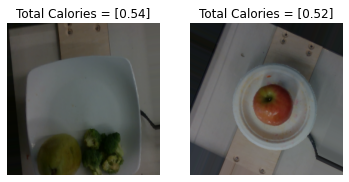

In [40]:
plt.figure(figsize=(6, 4))
for i in range(2):
  iterator = next(sample50_train_gen)
  image = iterator[0]
  tc = iterator[1]
  image = np.squeeze(image)
  plt.subplot(1,2,i+1)
  plt.imshow(image.astype('uint8'))
  plt.title("Total Calories = " + str(tc))
  plt.axis("off")

## Sample Batch Validation Images

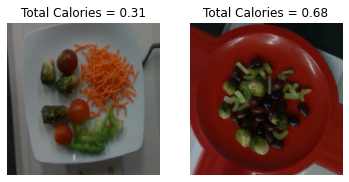

In [41]:
plt.figure(figsize=(6, 4))
for i in range(2):
  iterator = next(sample50_test_gen)
  image = iterator[0]
  tc = iterator[1]
  image = np.squeeze(image)
  plt.subplot(1,2,i+1)
  plt.imshow(image.astype('uint8'))
  label = round(tc[0] ,2)
  plt.title("Total Calories = " + str(label))
  plt.axis("off")

## Sample Patches (16 * 16)

Image size: 256 X 256
Patch size: 16 X 16
256 patches per image 
768 elements per patch


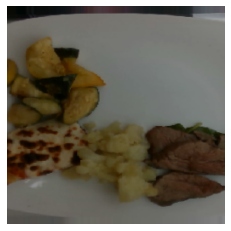

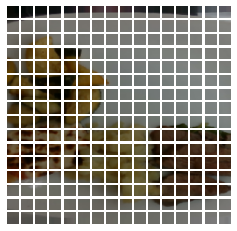

In [42]:
patch_size = 16  # Size of the patches to be extracted from the input images
image = next(sample50_train_gen)[0]
image = np.squeeze(image)
plt.figure(figsize=(4, 4))
plt.imshow(image.astype('uint8'))
plt.axis("off")

patches = Patches(vit_config_1)(tf.convert_to_tensor([image]))
print(f"Image size: {vit_config_1.image_size} X {vit_config_1.image_size}")
print(f"Patch size: {vit_config_1.patch_size} X {vit_config_1.patch_size}")
print(f"{patches.shape[1]} patches per image \n{patches.shape[-1]} elements per patch")


n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Training Model - 1

### Callbacks

In [43]:
callbackHelper = CallbackHelper(workspace)
model_checkpoint = callbackHelper.create_callback(callback_name="MC",experiment="/model-1")
tensorboard_callback = callbackHelper.create_callback(callback_name="TB",experiment="/model-1")
early_stop_callback = callbackHelper.create_callback(callback_name="ES",es_patience=0)
tqdm_callback = callbackHelper.create_callback(callback_name="TQDM")
callback_list = [tqdm_callback,model_checkpoint,tensorboard_callback]

Log file used =  /home/ubuntu/logs/model-1/20221124-203629/MC
Log file used =  /home/ubuntu/logs/model-1/20221124-203629/TB


### Compile

In [44]:
callback_list

In [45]:
vm_lr_1 = 1e-4
vit_model_1.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=vm_lr_1),
              loss="mean_squared_error",
              metrics="mean_absolute_error")

### Fit Model

In [46]:
batch = 10
num_epochs = 20

hist_model_1 = vit_model_1.fit(
        sample50_train_gen,
        validation_data = sample50_test_gen,
        batch_size=batch,
        epochs=num_epochs,
        callbacks= callback_list
    )

Training:   0%|           0/20 ETA: ?s,  ?epochs/s

Epoch 1/20


0/36           ETA: ?s - 

Epoch 1/20
34/36 [===========================>..] - ETA: 0s - loss: 28.5864 - mean_absolute_error: 4.4752

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-203629/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-203629/MC/assets


36/36 [==============================] - 21s 432ms/step - loss: 27.9597 - mean_absolute_error: 4.4575 - val_loss: 0.4318 - val_mean_absolute_error: 0.6107
Epoch 2/20


0/36           ETA: ?s - 

Epoch 2/20
35/36 [============================>.] - ETA: 0s - loss: 9.2723 - mean_absolute_error: 2.3960

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-203629/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-203629/MC/assets


36/36 [==============================] - 14s 402ms/step - loss: 9.0644 - mean_absolute_error: 2.3666 - val_loss: 0.3346 - val_mean_absolute_error: 0.5267
Epoch 3/20


0/36           ETA: ?s - 

Epoch 3/20
33/36 [==========================>...] - ETA: 0s - loss: 9.6793 - mean_absolute_error: 2.5501

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-203629/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-203629/MC/assets


36/36 [==============================] - 15s 421ms/step - loss: 9.8061 - mean_absolute_error: 2.5866 - val_loss: 0.3928 - val_mean_absolute_error: 0.5356
Epoch 4/20


0/36           ETA: ?s - 

Epoch 4/20
34/36 [===========================>..] - ETA: 0s - loss: 6.4906 - mean_absolute_error: 2.0068

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-203629/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-203629/MC/assets


36/36 [==============================] - 15s 420ms/step - loss: 6.4407 - mean_absolute_error: 2.0260 - val_loss: 0.5590 - val_mean_absolute_error: 0.5575
Epoch 5/20


0/36           ETA: ?s - 

Epoch 5/20
36/36 [==============================] - ETA: 0s - loss: 6.9923 - mean_absolute_error: 2.1146

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-203629/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-203629/MC/assets


36/36 [==============================] - 14s 408ms/step - loss: 6.9923 - mean_absolute_error: 2.1146 - val_loss: 0.4351 - val_mean_absolute_error: 0.5664
Epoch 6/20


0/36           ETA: ?s - 

Epoch 6/20
36/36 [==============================] - ETA: 0s - loss: 4.6768 - mean_absolute_error: 1.7659

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-203629/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-203629/MC/assets


36/36 [==============================] - 15s 427ms/step - loss: 4.6768 - mean_absolute_error: 1.7659 - val_loss: 4.7790 - val_mean_absolute_error: 2.0774
Epoch 7/20


0/36           ETA: ?s - 

Epoch 7/20
35/36 [============================>.] - ETA: 0s - loss: 5.8631 - mean_absolute_error: 1.8370

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-203629/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-203629/MC/assets


36/36 [==============================] - 14s 401ms/step - loss: 5.7754 - mean_absolute_error: 1.8316 - val_loss: 0.3066 - val_mean_absolute_error: 0.4698
Epoch 8/20


0/36           ETA: ?s - 

Epoch 8/20
34/36 [===========================>..] - ETA: 0s - loss: 5.3820 - mean_absolute_error: 1.6387

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-203629/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-203629/MC/assets


36/36 [==============================] - 15s 418ms/step - loss: 5.3962 - mean_absolute_error: 1.6488 - val_loss: 1.2674 - val_mean_absolute_error: 1.0299
Epoch 9/20


0/36           ETA: ?s - 

Epoch 9/20
36/36 [==============================] - ETA: 0s - loss: 5.6166 - mean_absolute_error: 1.9171

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-203629/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-203629/MC/assets


36/36 [==============================] - 15s 418ms/step - loss: 5.6166 - mean_absolute_error: 1.9171 - val_loss: 0.4324 - val_mean_absolute_error: 0.5162
Epoch 10/20


0/36           ETA: ?s - 

Epoch 10/20
35/36 [============================>.] - ETA: 0s - loss: 4.3547 - mean_absolute_error: 1.4480

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-203629/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-203629/MC/assets


36/36 [==============================] - 14s 401ms/step - loss: 4.4533 - mean_absolute_error: 1.4858 - val_loss: 0.4303 - val_mean_absolute_error: 0.4644
Epoch 11/20


0/36           ETA: ?s - 

Epoch 11/20
36/36 [==============================] - ETA: 0s - loss: 4.1655 - mean_absolute_error: 1.6397

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-203629/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-203629/MC/assets


36/36 [==============================] - 15s 420ms/step - loss: 4.1655 - mean_absolute_error: 1.6397 - val_loss: 0.5580 - val_mean_absolute_error: 0.5439
Epoch 12/20


0/36           ETA: ?s - 

Epoch 12/20
35/36 [============================>.] - ETA: 0s - loss: 3.7004 - mean_absolute_error: 1.4940

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-203629/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-203629/MC/assets


36/36 [==============================] - 15s 427ms/step - loss: 3.6029 - mean_absolute_error: 1.4647 - val_loss: 0.7224 - val_mean_absolute_error: 0.6899
Epoch 13/20


0/36           ETA: ?s - 

Epoch 13/20
35/36 [============================>.] - ETA: 0s - loss: 6.5086 - mean_absolute_error: 1.9502

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-203629/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-203629/MC/assets


36/36 [==============================] - 14s 403ms/step - loss: 6.6735 - mean_absolute_error: 1.9940 - val_loss: 0.4773 - val_mean_absolute_error: 0.6209
Epoch 14/20


0/36           ETA: ?s - 

Epoch 14/20
34/36 [===========================>..] - ETA: 0s - loss: 4.6220 - mean_absolute_error: 1.8114

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-203629/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-203629/MC/assets


36/36 [==============================] - 15s 421ms/step - loss: 4.3653 - mean_absolute_error: 1.7128 - val_loss: 0.3233 - val_mean_absolute_error: 0.5153
Epoch 15/20


0/36           ETA: ?s - 

Epoch 15/20
33/36 [==========================>...] - ETA: 0s - loss: 4.1793 - mean_absolute_error: 1.5544

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-203629/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-203629/MC/assets


36/36 [==============================] - 15s 419ms/step - loss: 4.0201 - mean_absolute_error: 1.5447 - val_loss: 0.6064 - val_mean_absolute_error: 0.6374
Epoch 16/20


0/36           ETA: ?s - 

Epoch 16/20
34/36 [===========================>..] - ETA: 0s - loss: 3.0322 - mean_absolute_error: 1.3254

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-203629/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-203629/MC/assets


36/36 [==============================] - 14s 399ms/step - loss: 2.9985 - mean_absolute_error: 1.3379 - val_loss: 0.3897 - val_mean_absolute_error: 0.4615
Epoch 17/20


0/36           ETA: ?s - 

Epoch 17/20
36/36 [==============================] - ETA: 0s - loss: 6.1146 - mean_absolute_error: 1.9113

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-203629/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-203629/MC/assets


36/36 [==============================] - 15s 420ms/step - loss: 6.1146 - mean_absolute_error: 1.9113 - val_loss: 0.3403 - val_mean_absolute_error: 0.4450
Epoch 18/20


0/36           ETA: ?s - 

Epoch 18/20
35/36 [============================>.] - ETA: 0s - loss: 3.1054 - mean_absolute_error: 1.4596

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-203629/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-203629/MC/assets


36/36 [==============================] - 15s 421ms/step - loss: 3.1243 - mean_absolute_error: 1.4731 - val_loss: 0.4875 - val_mean_absolute_error: 0.5652
Epoch 19/20


0/36           ETA: ?s - 

Epoch 19/20
34/36 [===========================>..] - ETA: 0s - loss: 3.4166 - mean_absolute_error: 1.3694

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-203629/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-203629/MC/assets


36/36 [==============================] - 14s 403ms/step - loss: 4.1731 - mean_absolute_error: 1.4784 - val_loss: 0.6805 - val_mean_absolute_error: 0.6856
Epoch 20/20


0/36           ETA: ?s - 

Epoch 20/20
34/36 [===========================>..] - ETA: 0s - loss: 4.3331 - mean_absolute_error: 1.6295

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-203629/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1/20221124-203629/MC/assets


36/36 [==============================] - 15s 424ms/step - loss: 4.1225 - mean_absolute_error: 1.5761 - val_loss: 0.3164 - val_mean_absolute_error: 0.4770


In [50]:
!nvidia-smi

Thu Nov 24 20:45:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   33C    P0    73W / 400W |  39241MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [47]:
print(STOP HERE)

SyntaxError: invalid syntax (<ipython-input-47-0f3958852a5c>, line 1)

## Tensorboard

### Upload to tensorboard

In [ ]:
# %load_ext tensorboard

In [ ]:
# %tensorboard --logdir '/home/ubuntu/logs/model-1/20221124-185054/TB/' 

In [ ]:
# !tensorboard dev upload --logdir '/home/ubuntu/logs/model-1/20221124-185054/TB/'  --name "Prototype - 50" --description "Training on 50 sample dish images" 

In [ ]:
hist_model_1

### Plot Function

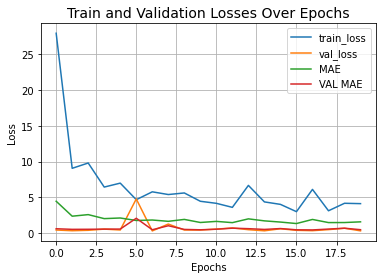

In [48]:
plt.plot(hist_model_1.history["loss"], label="train_loss")
plt.plot(hist_model_1.history["val_loss"], label="val_loss")
plt.plot(hist_model_1.history["mean_absolute_error"], label="MAE")
plt.plot(hist_model_1.history["val_mean_absolute_error"], label="VAL MAE")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

## Training Model - 1 with 100 records

### Sample 100 Images for Prototype

### Train/Test Split

In [51]:
SAMPLE_SIZE = 100
sample100_data = dish_info.sample(n=SAMPLE_SIZE)
print(sample100_data.shape)

(100, 7)


In [52]:
sample100_data.head()

,dish_id,total_calories,total_mass,total_fat,total_carb,total_protein,image_path
194,dish_1558029148,38.880001,108.0,0.108000,9.720000,0.540000,/home/ubuntu/dataset/processed_overhead/dish_1...
859,dish_1561661377,306.333679,294.0,8.972795,11.854835,43.735157,/home/ubuntu/dataset/processed_overhead/dish_1...
1580,dish_1564777986,372.230896,221.0,18.809000,21.323952,28.163883,/home/ubuntu/dataset/processed_overhead/dish_1...
1490,dish_1563564797,411.264465,310.0,24.779562,30.171246,32.680634,/home/ubuntu/dataset/processed_overhead/dish_1...
2237,dish_1568649430,363.658203,327.0,20.152399,30.648777,16.012787,/home/ubuntu/dataset/processed_overhead/dish_1...


In [ ]:
# cropped_image_path = workspace + '/processed_overhead/'
# sample50_data.dish_id.apply(lambda x :  cropped_image_path + x + '/cropped.png')

In [53]:
fractions = np.array([0.8, 0.1, 0.1])
# shuffle
df = sample100_data.sample(frac=1) 
# split into 3 parts
train_100, val_100, test_100 = np.array_split(
    df, (fractions[:-1].cumsum() * len(df)).astype(int))
print(train_100.shape)
print(val_100.shape)
print(test_100.shape)
sample100_data = pd.concat([train_100,val_100])
sample100_data.shape

(80, 7)
(10, 7)
(10, 7)


(90, 7)

### Normalize total_calories
* Divide it by total_mass of the dish 

In [54]:
sample100_data["total_calories_norm"] = round(sample100_data["total_calories"]/sample100_data["total_mass"],2)

In [55]:
sample100_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90 entries, 1960 to 2088
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dish_id              90 non-null     object 
 1   total_calories       90 non-null     float32
 2   total_mass           90 non-null     float32
 3   total_fat            90 non-null     float32
 4   total_carb           90 non-null     float32
 5   total_protein        90 non-null     float32
 6   image_path           90 non-null     object 
 7   total_calories_norm  90 non-null     float32
dtypes: float32(6), object(2)
memory usage: 4.2+ KB


### Data Generator

In [56]:
sample100_train_gen  = generator.flow_from_dataframe(dataframe=sample100_data,
                              target_size=(256,256),
                              x_col="image_path",
                              class_mode ="raw",
                              directory=None,
                              y_col = "total_calories_norm",
                              batch_size=1,
                              shuffle=True,
                              subset="training",
                              seed=123,
                              rescale=1.0/255)
sample100_test_gen  = generator.flow_from_dataframe(dataframe=sample100_data,
                              target_size=(256,256),
                              x_col="image_path",
                              class_mode ="raw",
                              directory=None,
                              batch_size=1,
                              seed=123,
                              y_col = "total_calories_norm",
                              subset="validation",
                              rescale=1.0/255)

Found 72 validated image filenames.
Found 18 validated image filenames.


### Callbacks

In [58]:
callbackHelper1 = CallbackHelper(workspace)
model_checkpoint1 = callbackHelper1.create_callback(callback_name="MC",experiment="/model-1_100")
tensorboard_callback1 = callbackHelper1.create_callback(callback_name="TB",experiment="/model-1_100")
early_stop_callback1 = callbackHelper1.create_callback(callback_name="ES",es_patience=0)
tqdm_callback1 = callbackHelper1.create_callback(callback_name="TQDM")
callback_list1 = [tqdm_callback1,model_checkpoint1,tensorboard_callback1]

Log file used =  /home/ubuntu/logs/model-1_100/20221124-204736/MC
Log file used =  /home/ubuntu/logs/model-1_100/20221124-204736/TB


In [59]:
callback_list1

### Fit Model

In [60]:
batch1 = 10
num_epochs1 = 20

model_1_hist1 = vit_model_1.fit(
        sample100_train_gen,
        validation_data = sample100_test_gen,
        batch_size=batch1,
        epochs=num_epochs1,
        callbacks= callback_list1
    )

Training:   0%|           0/20 ETA: ?s,  ?epochs/s

Epoch 1/20


0/72           ETA: ?s - 

Epoch 1/20
70/72 [============================>.] - ETA: 0s - loss: 4.1097 - mean_absolute_error: 1.6293

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100/20221124-204736/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100/20221124-204736/MC/assets


72/72 [==============================] - 15s 208ms/step - loss: 4.0041 - mean_absolute_error: 1.5976 - val_loss: 0.3754 - val_mean_absolute_error: 0.4912
Epoch 2/20


0/72           ETA: ?s - 

Epoch 2/20
70/72 [============================>.] - ETA: 0s - loss: 3.9518 - mean_absolute_error: 1.5832

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100/20221124-204736/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100/20221124-204736/MC/assets


72/72 [==============================] - 16s 218ms/step - loss: 3.9424 - mean_absolute_error: 1.5911 - val_loss: 0.6016 - val_mean_absolute_error: 0.6851
Epoch 3/20


0/72           ETA: ?s - 

Epoch 3/20
69/72 [===========================>..] - ETA: 0s - loss: 4.5293 - mean_absolute_error: 1.5618

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100/20221124-204736/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100/20221124-204736/MC/assets


72/72 [==============================] - 15s 217ms/step - loss: 4.3464 - mean_absolute_error: 1.5093 - val_loss: 0.3882 - val_mean_absolute_error: 0.5184
Epoch 4/20


0/72           ETA: ?s - 

Epoch 4/20
72/72 [==============================] - ETA: 0s - loss: 3.3408 - mean_absolute_error: 1.3742

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100/20221124-204736/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100/20221124-204736/MC/assets


72/72 [==============================] - 15s 209ms/step - loss: 3.3408 - mean_absolute_error: 1.3742 - val_loss: 0.1881 - val_mean_absolute_error: 0.3360
Epoch 5/20


0/72           ETA: ?s - 

Epoch 5/20
70/72 [============================>.] - ETA: 0s - loss: 3.6057 - mean_absolute_error: 1.4506

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100/20221124-204736/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100/20221124-204736/MC/assets


72/72 [==============================] - 16s 218ms/step - loss: 3.5379 - mean_absolute_error: 1.4387 - val_loss: 0.4897 - val_mean_absolute_error: 0.6003
Epoch 6/20


0/72           ETA: ?s - 

Epoch 6/20
71/72 [============================>.] - ETA: 0s - loss: 3.7891 - mean_absolute_error: 1.5064

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100/20221124-204736/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100/20221124-204736/MC/assets


72/72 [==============================] - 15s 217ms/step - loss: 3.7443 - mean_absolute_error: 1.4959 - val_loss: 0.1889 - val_mean_absolute_error: 0.3683
Epoch 7/20


0/72           ETA: ?s - 

Epoch 7/20
70/72 [============================>.] - ETA: 0s - loss: 3.8183 - mean_absolute_error: 1.4535

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100/20221124-204736/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100/20221124-204736/MC/assets


72/72 [==============================] - 15s 212ms/step - loss: 3.7421 - mean_absolute_error: 1.4417 - val_loss: 0.2108 - val_mean_absolute_error: 0.3683
Epoch 8/20


0/72           ETA: ?s - 

Epoch 8/20
71/72 [============================>.] - ETA: 0s - loss: 2.8437 - mean_absolute_error: 1.3107

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100/20221124-204736/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100/20221124-204736/MC/assets


72/72 [==============================] - 15s 218ms/step - loss: 2.8043 - mean_absolute_error: 1.2940 - val_loss: 0.6809 - val_mean_absolute_error: 0.7285
Epoch 9/20


0/72           ETA: ?s - 

Epoch 9/20
71/72 [============================>.] - ETA: 0s - loss: 2.7739 - mean_absolute_error: 1.2336

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100/20221124-204736/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100/20221124-204736/MC/assets


72/72 [==============================] - 15s 217ms/step - loss: 2.7563 - mean_absolute_error: 1.2335 - val_loss: 0.2049 - val_mean_absolute_error: 0.3513
Epoch 10/20


0/72           ETA: ?s - 

Epoch 10/20
71/72 [============================>.] - ETA: 0s - loss: 2.6680 - mean_absolute_error: 1.2354

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100/20221124-204736/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100/20221124-204736/MC/assets


72/72 [==============================] - 15s 208ms/step - loss: 2.6456 - mean_absolute_error: 1.2325 - val_loss: 0.5032 - val_mean_absolute_error: 0.6129
Epoch 11/20


0/72           ETA: ?s - 

Epoch 11/20
70/72 [============================>.] - ETA: 0s - loss: 3.9004 - mean_absolute_error: 1.4161

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100/20221124-204736/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100/20221124-204736/MC/assets


72/72 [==============================] - 16s 218ms/step - loss: 3.8381 - mean_absolute_error: 1.4095 - val_loss: 0.2463 - val_mean_absolute_error: 0.3959
Epoch 12/20


0/72           ETA: ?s - 

Epoch 12/20
72/72 [==============================] - ETA: 0s - loss: 2.7464 - mean_absolute_error: 1.2285

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100/20221124-204736/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100/20221124-204736/MC/assets


72/72 [==============================] - 16s 218ms/step - loss: 2.7464 - mean_absolute_error: 1.2285 - val_loss: 0.7251 - val_mean_absolute_error: 0.7612
Epoch 13/20


0/72           ETA: ?s - 

Epoch 13/20
71/72 [============================>.] - ETA: 0s - loss: 2.8007 - mean_absolute_error: 1.3470

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100/20221124-204736/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100/20221124-204736/MC/assets


72/72 [==============================] - 15s 208ms/step - loss: 2.7765 - mean_absolute_error: 1.3426 - val_loss: 0.1394 - val_mean_absolute_error: 0.2786
Epoch 14/20


0/72           ETA: ?s - 

Epoch 14/20
72/72 [==============================] - ETA: 0s - loss: 2.9279 - mean_absolute_error: 1.3147

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100/20221124-204736/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100/20221124-204736/MC/assets


72/72 [==============================] - 16s 219ms/step - loss: 2.9279 - mean_absolute_error: 1.3147 - val_loss: 0.8832 - val_mean_absolute_error: 0.8592
Epoch 15/20


0/72           ETA: ?s - 

Epoch 15/20
72/72 [==============================] - ETA: 0s - loss: 2.8928 - mean_absolute_error: 1.2785

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100/20221124-204736/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100/20221124-204736/MC/assets


72/72 [==============================] - 15s 217ms/step - loss: 2.8928 - mean_absolute_error: 1.2785 - val_loss: 0.4194 - val_mean_absolute_error: 0.5604
Epoch 16/20


0/72           ETA: ?s - 

Epoch 16/20
71/72 [============================>.] - ETA: 0s - loss: 3.1162 - mean_absolute_error: 1.2785

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100/20221124-204736/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100/20221124-204736/MC/assets


72/72 [==============================] - 15s 208ms/step - loss: 3.0926 - mean_absolute_error: 1.2773 - val_loss: 0.8033 - val_mean_absolute_error: 0.8084
Epoch 17/20


0/72           ETA: ?s - 

Epoch 17/20
71/72 [============================>.] - ETA: 0s - loss: 2.4287 - mean_absolute_error: 1.1945

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100/20221124-204736/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100/20221124-204736/MC/assets


72/72 [==============================] - 16s 220ms/step - loss: 2.3993 - mean_absolute_error: 1.1857 - val_loss: 0.9600 - val_mean_absolute_error: 0.9024
Epoch 18/20


0/72           ETA: ?s - 

Epoch 18/20
69/72 [===========================>..] - ETA: 0s - loss: 3.1029 - mean_absolute_error: 1.2964

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100/20221124-204736/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100/20221124-204736/MC/assets


72/72 [==============================] - 15s 207ms/step - loss: 2.9868 - mean_absolute_error: 1.2613 - val_loss: 0.4286 - val_mean_absolute_error: 0.5522
Epoch 19/20


0/72           ETA: ?s - 

Epoch 19/20
71/72 [============================>.] - ETA: 0s - loss: 1.6713 - mean_absolute_error: 1.0053

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100/20221124-204736/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100/20221124-204736/MC/assets


72/72 [==============================] - 15s 218ms/step - loss: 1.7052 - mean_absolute_error: 1.0195 - val_loss: 0.2667 - val_mean_absolute_error: 0.4193
Epoch 20/20


0/72           ETA: ?s - 

Epoch 20/20
69/72 [===========================>..] - ETA: 0s - loss: 2.6206 - mean_absolute_error: 1.1555

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100/20221124-204736/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100/20221124-204736/MC/assets


72/72 [==============================] - 15s 217ms/step - loss: 2.5468 - mean_absolute_error: 1.1370 - val_loss: 0.8658 - val_mean_absolute_error: 0.8450


In [61]:
!nvidia-smi

Thu Nov 24 20:56:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   32C    P0    54W / 400W |  39241MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
### Plots

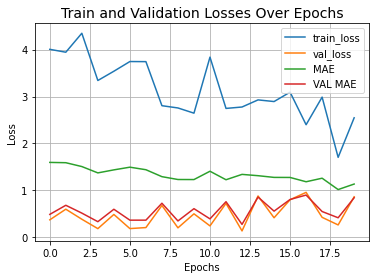

In [62]:
plt.plot(model_1_hist1.history["loss"], label="train_loss")
plt.plot(model_1_hist1.history["val_loss"], label="val_loss")
plt.plot(model_1_hist1.history["mean_absolute_error"], label="MAE")
plt.plot(model_1_hist1.history["val_mean_absolute_error"], label="VAL MAE")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

## Training Model - 1 with 100 records and batch - 20

### Callbacks

In [64]:
callbackHelper2 = CallbackHelper(workspace)
model_checkpoint2 = callbackHelper2.create_callback(callback_name="MC",experiment="/model-1_100_20")
tensorboard_callback2 = callbackHelper2.create_callback(callback_name="TB",experiment="/model-1_100_20")
early_stop_callback2 = callbackHelper2.create_callback(callback_name="ES",es_patience=0)
tqdm_callback2 = callbackHelper2.create_callback(callback_name="TQDM")
callback_list2 = [tqdm_callback2,model_checkpoint2,tensorboard_callback2]

Log file used =  /home/ubuntu/logs/model-1_100_20/20221124-205940/MC
Log file used =  /home/ubuntu/logs/model-1_100_20/20221124-205940/TB


In [65]:
callback_list2

### Fit Model

In [66]:
batch2 = 20
num_epochs2 = 20

model_1_hist2 = vit_model_1.fit(
        sample100_train_gen,
        validation_data = sample100_test_gen,
        batch_size=batch2,
        epochs=num_epochs2,
        callbacks = callback_list2
    )

Training:   0%|           0/20 ETA: ?s,  ?epochs/s

Epoch 1/20


0/72           ETA: ?s - 

Epoch 1/20
 4/72 [>.............................] - ETA: 1s - loss: 2.1766 - mean_absolute_error: 1.2502WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0147s vs `on_train_batch_end` time: 0.0153s). Check your callbacks.


69/72 [===========================>..] - ETA: 0s - loss: 3.1112 - mean_absolute_error: 1.3116

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100_20/20221124-205940/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100_20/20221124-205940/MC/assets


72/72 [==============================] - 15s 208ms/step - loss: 3.1851 - mean_absolute_error: 1.3195 - val_loss: 0.8011 - val_mean_absolute_error: 0.8050
Epoch 2/20


0/72           ETA: ?s - 

Epoch 2/20
71/72 [============================>.] - ETA: 0s - loss: 2.1389 - mean_absolute_error: 1.1075

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100_20/20221124-205940/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100_20/20221124-205940/MC/assets


72/72 [==============================] - 16s 220ms/step - loss: 2.1182 - mean_absolute_error: 1.1034 - val_loss: 0.4644 - val_mean_absolute_error: 0.5844
Epoch 3/20


0/72           ETA: ?s - 

Epoch 3/20
71/72 [============================>.] - ETA: 0s - loss: 2.3092 - mean_absolute_error: 1.1742

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100_20/20221124-205940/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100_20/20221124-205940/MC/assets


72/72 [==============================] - 16s 218ms/step - loss: 2.3157 - mean_absolute_error: 1.1810 - val_loss: 0.2010 - val_mean_absolute_error: 0.3534
Epoch 4/20


0/72           ETA: ?s - 

Epoch 4/20
70/72 [============================>.] - ETA: 0s - loss: 2.6141 - mean_absolute_error: 1.1567

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100_20/20221124-205940/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100_20/20221124-205940/MC/assets


72/72 [==============================] - 15s 208ms/step - loss: 2.5649 - mean_absolute_error: 1.1428 - val_loss: 0.4733 - val_mean_absolute_error: 0.5926
Epoch 5/20


0/72           ETA: ?s - 

Epoch 5/20
69/72 [===========================>..] - ETA: 0s - loss: 3.0628 - mean_absolute_error: 1.3065

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100_20/20221124-205940/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100_20/20221124-205940/MC/assets


72/72 [==============================] - 16s 220ms/step - loss: 2.9819 - mean_absolute_error: 1.2880 - val_loss: 0.5330 - val_mean_absolute_error: 0.6324
Epoch 6/20


0/72           ETA: ?s - 

Epoch 6/20
70/72 [============================>.] - ETA: 0s - loss: 2.8115 - mean_absolute_error: 1.2770

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100_20/20221124-205940/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100_20/20221124-205940/MC/assets


72/72 [==============================] - 15s 208ms/step - loss: 2.7661 - mean_absolute_error: 1.2645 - val_loss: 0.4405 - val_mean_absolute_error: 0.5657
Epoch 7/20


0/72           ETA: ?s - 

Epoch 7/20
70/72 [============================>.] - ETA: 0s - loss: 2.6469 - mean_absolute_error: 1.1501

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100_20/20221124-205940/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100_20/20221124-205940/MC/assets


72/72 [==============================] - 16s 219ms/step - loss: 2.7084 - mean_absolute_error: 1.1680 - val_loss: 0.5500 - val_mean_absolute_error: 0.6474
Epoch 8/20


0/72           ETA: ?s - 

Epoch 8/20
71/72 [============================>.] - ETA: 0s - loss: 2.1111 - mean_absolute_error: 1.0482

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100_20/20221124-205940/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100_20/20221124-205940/MC/assets


72/72 [==============================] - 15s 216ms/step - loss: 2.1475 - mean_absolute_error: 1.0638 - val_loss: 0.4599 - val_mean_absolute_error: 0.5826
Epoch 9/20


0/72           ETA: ?s - 

Epoch 9/20
69/72 [===========================>..] - ETA: 0s - loss: 2.9926 - mean_absolute_error: 1.3069

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100_20/20221124-205940/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100_20/20221124-205940/MC/assets


72/72 [==============================] - 15s 208ms/step - loss: 2.9020 - mean_absolute_error: 1.2840 - val_loss: 0.4812 - val_mean_absolute_error: 0.5941
Epoch 10/20


0/72           ETA: ?s - 

Epoch 10/20
69/72 [===========================>..] - ETA: 0s - loss: 2.0887 - mean_absolute_error: 1.0627

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100_20/20221124-205940/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100_20/20221124-205940/MC/assets


72/72 [==============================] - 16s 218ms/step - loss: 2.3215 - mean_absolute_error: 1.1078 - val_loss: 0.2887 - val_mean_absolute_error: 0.4434
Epoch 11/20


0/72           ETA: ?s - 

Epoch 11/20
71/72 [============================>.] - ETA: 0s - loss: 2.8184 - mean_absolute_error: 1.1695

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100_20/20221124-205940/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100_20/20221124-205940/MC/assets


72/72 [==============================] - 15s 216ms/step - loss: 2.7829 - mean_absolute_error: 1.1604 - val_loss: 0.4126 - val_mean_absolute_error: 0.5432
Epoch 12/20


0/72           ETA: ?s - 

Epoch 12/20
69/72 [===========================>..] - ETA: 0s - loss: 2.3561 - mean_absolute_error: 1.0870

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100_20/20221124-205940/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100_20/20221124-205940/MC/assets


72/72 [==============================] - 15s 207ms/step - loss: 2.3098 - mean_absolute_error: 1.0876 - val_loss: 0.5022 - val_mean_absolute_error: 0.6129
Epoch 13/20


0/72           ETA: ?s - 

Epoch 13/20
69/72 [===========================>..] - ETA: 0s - loss: 2.6485 - mean_absolute_error: 1.2074

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100_20/20221124-205940/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100_20/20221124-205940/MC/assets


72/72 [==============================] - 16s 218ms/step - loss: 2.5616 - mean_absolute_error: 1.1865 - val_loss: 0.5449 - val_mean_absolute_error: 0.6448
Epoch 14/20


0/72           ETA: ?s - 

Epoch 14/20
72/72 [==============================] - ETA: 0s - loss: 2.0633 - mean_absolute_error: 1.0781

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100_20/20221124-205940/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100_20/20221124-205940/MC/assets


72/72 [==============================] - 15s 216ms/step - loss: 2.0633 - mean_absolute_error: 1.0781 - val_loss: 0.6446 - val_mean_absolute_error: 0.7114
Epoch 15/20


0/72           ETA: ?s - 

Epoch 15/20
70/72 [============================>.] - ETA: 0s - loss: 1.3229 - mean_absolute_error: 0.8563

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100_20/20221124-205940/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100_20/20221124-205940/MC/assets


72/72 [==============================] - 15s 207ms/step - loss: 1.4456 - mean_absolute_error: 0.8893 - val_loss: 0.1772 - val_mean_absolute_error: 0.3219
Epoch 16/20


0/72           ETA: ?s - 

Epoch 16/20
70/72 [============================>.] - ETA: 0s - loss: 3.2570 - mean_absolute_error: 1.2916

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100_20/20221124-205940/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100_20/20221124-205940/MC/assets


72/72 [==============================] - 16s 219ms/step - loss: 3.1969 - mean_absolute_error: 1.2821 - val_loss: 0.3703 - val_mean_absolute_error: 0.5073
Epoch 17/20


0/72           ETA: ?s - 

Epoch 17/20
70/72 [============================>.] - ETA: 0s - loss: 2.2248 - mean_absolute_error: 1.1222

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100_20/20221124-205940/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100_20/20221124-205940/MC/assets


72/72 [==============================] - 15s 216ms/step - loss: 2.5769 - mean_absolute_error: 1.1801 - val_loss: 0.2269 - val_mean_absolute_error: 0.3897
Epoch 18/20


0/72           ETA: ?s - 

Epoch 18/20
69/72 [===========================>..] - ETA: 0s - loss: 2.1909 - mean_absolute_error: 1.0433

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100_20/20221124-205940/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100_20/20221124-205940/MC/assets


72/72 [==============================] - 15s 207ms/step - loss: 2.1210 - mean_absolute_error: 1.0267 - val_loss: 0.5646 - val_mean_absolute_error: 0.6587
Epoch 19/20


0/72           ETA: ?s - 

Epoch 19/20
70/72 [============================>.] - ETA: 0s - loss: 2.3583 - mean_absolute_error: 1.1964

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100_20/20221124-205940/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100_20/20221124-205940/MC/assets


72/72 [==============================] - 16s 220ms/step - loss: 2.3264 - mean_absolute_error: 1.1917 - val_loss: 0.2986 - val_mean_absolute_error: 0.4447
Epoch 20/20


0/72           ETA: ?s - 

Epoch 20/20
72/72 [==============================] - ETA: 0s - loss: 2.4260 - mean_absolute_error: 1.0488

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100_20/20221124-205940/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100_20/20221124-205940/MC/assets


72/72 [==============================] - 15s 208ms/step - loss: 2.4260 - mean_absolute_error: 1.0488 - val_loss: 0.7544 - val_mean_absolute_error: 0.7810


In [67]:
!nvidia-smi

Thu Nov 24 21:13:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   33C    P0    73W / 400W |  39241MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
### Plots

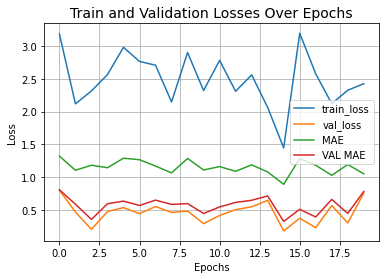

In [68]:
plt.plot(model_1_hist2.history["loss"], label="train_loss")
plt.plot(model_1_hist2.history["val_loss"], label="val_loss")
plt.plot(model_1_hist2.history["mean_absolute_error"], label="MAE")
plt.plot(model_1_hist2.history["val_mean_absolute_error"], label="VAL MAE")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

## Training Model - 1 with 40% records and batch - 30

### Callbacks

In [69]:
callbackHelper3 = CallbackHelper(workspace)
model_checkpoint3 = callbackHelper3.create_callback(callback_name="MC",experiment="/model-1_30P_20")
tensorboard_callback3 = callbackHelper3.create_callback(callback_name="TB",experiment="/model-1_30P_20")
early_stop_callback3 = callbackHelper3.create_callback(callback_name="ES",es_patience=0)
tqdm_callback3 = callbackHelper3.create_callback(callback_name="TQDM")
callback_list3 = [tqdm_callback3,model_checkpoint3,tensorboard_callback3]

Log file used =  /home/ubuntu/logs/model-1_30P_20/20221124-211624/MC
Log file used =  /home/ubuntu/logs/model-1_30P_20/20221124-211624/TB


In [70]:
callback_list3

### Sample 40% Images for Prototype

### Train/Test Split

In [74]:
SAMPLE_SIZE = 0.4
sample30P_data = dish_info.sample(frac=SAMPLE_SIZE)
print(sample30P_data.shape)

(1304, 7)


In [75]:
sample30P_data.head()

,dish_id,total_calories,total_mass,total_fat,total_carb,total_protein,image_path
3085,dish_1558629444,225.459000,39.0,19.305000,8.853000,8.736000,/home/ubuntu/dataset/processed_overhead/dish_1...
1429,dish_1557936599,22.049999,63.0,0.252000,4.410000,1.512000,/home/ubuntu/dataset/processed_overhead/dish_1...
365,dish_1568401302,716.479370,561.0,28.946722,69.864967,44.677963,/home/ubuntu/dataset/processed_overhead/dish_1...
329,dish_1558641954,18.360001,102.0,0.204000,3.978000,0.918000,/home/ubuntu/dataset/processed_overhead/dish_1...
514,dish_1563566810,392.292175,331.0,18.451838,51.255371,9.994014,/home/ubuntu/dataset/processed_overhead/dish_1...


In [ ]:
# cropped_image_path = workspace + '/processed_overhead/'
# sample50_data.dish_id.apply(lambda x :  cropped_image_path + x + '/cropped.png')

In [76]:
fractions = np.array([0.8, 0.1, 0.1])
# shuffle
df = sample30P_data.sample(frac=1) 
# split into 3 parts
train_30P, val_30P, test_30P = np.array_split(
    df, (fractions[:-1].cumsum() * len(df)).astype(int))
print(train_30P.shape)
print(val_30P.shape)
print(test_30P.shape)
sample30P_data = pd.concat([train_30P,val_30P])
sample30P_data.shape

(1043, 7)
(130, 7)
(131, 7)


(1173, 7)

### Normalize total_calories
* Divide it by total_mass of the dish 

In [77]:
sample30P_data["total_calories_norm"] = round(sample30P_data["total_calories"]/sample30P_data["total_mass"],2)

In [78]:
sample30P_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1173 entries, 2603 to 1295
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dish_id              1173 non-null   object 
 1   total_calories       1173 non-null   float32
 2   total_mass           1173 non-null   float32
 3   total_fat            1173 non-null   float32
 4   total_carb           1173 non-null   float32
 5   total_protein        1173 non-null   float32
 6   image_path           1173 non-null   object 
 7   total_calories_norm  1173 non-null   float32
dtypes: float32(6), object(2)
memory usage: 55.0+ KB


### Data Generator

In [79]:
sample30P_train_gen  = generator.flow_from_dataframe(dataframe=sample30P_data,
                              target_size=(256,256),
                              x_col="image_path",
                              class_mode ="raw",
                              directory=None,
                              y_col = "total_calories_norm",
                              batch_size=1,
                              shuffle=True,
                              subset="training",
                              seed=123,
                              rescale=1.0/255)
sample30P_test_gen  = generator.flow_from_dataframe(dataframe=sample30P_data,
                              target_size=(256,256),
                              x_col="image_path",
                              class_mode ="raw",
                              directory=None,
                              batch_size=1,
                              seed=123,
                              y_col = "total_calories_norm",
                              subset="validation",
                              rescale=1.0/255)

Found 939 validated image filenames.
Found 234 validated image filenames.


### Fit Model

In [80]:
batch3 = 30
num_epochs3 = 20

model_1_hist3 = vit_model_1.fit(
        sample30P_train_gen,
        validation_data = sample30P_test_gen,
        batch_size=batch3,
        epochs=num_epochs3,
        callbacks = callback_list3
    )

Training:   0%|           0/20 ETA: ?s,  ?epochs/s

Epoch 1/20


0/939           ETA: ?s - 

Epoch 1/20
938/939 [============================>.] - ETA: 0s - loss: 2.0377 - mean_absolute_error: 0.9870

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_30P_20/20221124-211624/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_30P_20/20221124-211624/MC/assets


939/939 [==============================] - 34s 36ms/step - loss: 2.0357 - mean_absolute_error: 0.9863 - val_loss: 1.3734 - val_mean_absolute_error: 0.7479
Epoch 2/20


0/939           ETA: ?s - 

Epoch 2/20
939/939 [==============================] - ETA: 0s - loss: 1.8542 - mean_absolute_error: 0.9429

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_30P_20/20221124-211624/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_30P_20/20221124-211624/MC/assets


939/939 [==============================] - 33s 35ms/step - loss: 1.8542 - mean_absolute_error: 0.9429 - val_loss: 1.4661 - val_mean_absolute_error: 0.7856
Epoch 3/20


0/939           ETA: ?s - 

Epoch 3/20
938/939 [============================>.] - ETA: 0s - loss: 1.6331 - mean_absolute_error: 0.8766

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_30P_20/20221124-211624/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_30P_20/20221124-211624/MC/assets


939/939 [==============================] - 33s 35ms/step - loss: 1.6317 - mean_absolute_error: 0.8763 - val_loss: 1.2007 - val_mean_absolute_error: 0.6818
Epoch 4/20


0/939           ETA: ?s - 

Epoch 4/20
939/939 [==============================] - ETA: 0s - loss: 1.6829 - mean_absolute_error: 0.8854

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_30P_20/20221124-211624/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_30P_20/20221124-211624/MC/assets


939/939 [==============================] - 33s 36ms/step - loss: 1.6829 - mean_absolute_error: 0.8854 - val_loss: 1.2390 - val_mean_absolute_error: 0.6953
Epoch 5/20


0/939           ETA: ?s - 

Epoch 5/20
936/939 [============================>.] - ETA: 0s - loss: 1.5925 - mean_absolute_error: 0.8344

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_30P_20/20221124-211624/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_30P_20/20221124-211624/MC/assets


939/939 [==============================] - 34s 37ms/step - loss: 1.5890 - mean_absolute_error: 0.8337 - val_loss: 1.0561 - val_mean_absolute_error: 0.6296
Epoch 6/20


0/939           ETA: ?s - 

Epoch 6/20
938/939 [============================>.] - ETA: 0s - loss: 1.5294 - mean_absolute_error: 0.8057

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_30P_20/20221124-211624/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_30P_20/20221124-211624/MC/assets


939/939 [==============================] - 33s 35ms/step - loss: 1.5289 - mean_absolute_error: 0.8059 - val_loss: 1.1921 - val_mean_absolute_error: 0.6787
Epoch 7/20


0/939           ETA: ?s - 

Epoch 7/20
937/939 [============================>.] - ETA: 0s - loss: 1.4779 - mean_absolute_error: 0.7841

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_30P_20/20221124-211624/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_30P_20/20221124-211624/MC/assets


939/939 [==============================] - 33s 35ms/step - loss: 1.4793 - mean_absolute_error: 0.7854 - val_loss: 1.2152 - val_mean_absolute_error: 0.6867
Epoch 8/20


0/939           ETA: ?s - 

Epoch 8/20
937/939 [============================>.] - ETA: 0s - loss: 1.4888 - mean_absolute_error: 0.7962

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_30P_20/20221124-211624/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_30P_20/20221124-211624/MC/assets


939/939 [==============================] - 33s 35ms/step - loss: 1.5009 - mean_absolute_error: 0.7990 - val_loss: 1.0542 - val_mean_absolute_error: 0.6295
Epoch 9/20


0/939           ETA: ?s - 

Epoch 9/20
936/939 [============================>.] - ETA: 0s - loss: 1.4246 - mean_absolute_error: 0.7656

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_30P_20/20221124-211624/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_30P_20/20221124-211624/MC/assets


939/939 [==============================] - 33s 36ms/step - loss: 1.4226 - mean_absolute_error: 0.7653 - val_loss: 1.0005 - val_mean_absolute_error: 0.6110
Epoch 10/20


0/939           ETA: ?s - 

Epoch 10/20
937/939 [============================>.] - ETA: 0s - loss: 1.3990 - mean_absolute_error: 0.7614

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_30P_20/20221124-211624/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_30P_20/20221124-211624/MC/assets


939/939 [==============================] - 33s 35ms/step - loss: 1.3962 - mean_absolute_error: 0.7603 - val_loss: 1.1041 - val_mean_absolute_error: 0.6467
Epoch 11/20


0/939           ETA: ?s - 

Epoch 11/20
937/939 [============================>.] - ETA: 0s - loss: 1.3751 - mean_absolute_error: 0.7469

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_30P_20/20221124-211624/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_30P_20/20221124-211624/MC/assets


939/939 [==============================] - 32s 35ms/step - loss: 1.3722 - mean_absolute_error: 0.7456 - val_loss: 1.0279 - val_mean_absolute_error: 0.6203
Epoch 12/20


0/939           ETA: ?s - 

Epoch 12/20
937/939 [============================>.] - ETA: 0s - loss: 1.3455 - mean_absolute_error: 0.7387

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_30P_20/20221124-211624/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_30P_20/20221124-211624/MC/assets


939/939 [==============================] - 33s 36ms/step - loss: 1.3442 - mean_absolute_error: 0.7388 - val_loss: 1.0241 - val_mean_absolute_error: 0.6189
Epoch 13/20


0/939           ETA: ?s - 

Epoch 13/20
936/939 [============================>.] - ETA: 0s - loss: 1.3391 - mean_absolute_error: 0.7318

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_30P_20/20221124-211624/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_30P_20/20221124-211624/MC/assets


939/939 [==============================] - 33s 35ms/step - loss: 1.3357 - mean_absolute_error: 0.7308 - val_loss: 0.9656 - val_mean_absolute_error: 0.6155
Epoch 14/20


0/939           ETA: ?s - 

Epoch 14/20
939/939 [==============================] - ETA: 0s - loss: 1.3029 - mean_absolute_error: 0.7247

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_30P_20/20221124-211624/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_30P_20/20221124-211624/MC/assets


939/939 [==============================] - 33s 35ms/step - loss: 1.3029 - mean_absolute_error: 0.7247 - val_loss: 0.9675 - val_mean_absolute_error: 0.6140
Epoch 15/20


0/939           ETA: ?s - 

Epoch 15/20
939/939 [==============================] - ETA: 0s - loss: 1.2997 - mean_absolute_error: 0.7299

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_30P_20/20221124-211624/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_30P_20/20221124-211624/MC/assets


939/939 [==============================] - 33s 35ms/step - loss: 1.2997 - mean_absolute_error: 0.7299 - val_loss: 0.9772 - val_mean_absolute_error: 0.6097
Epoch 16/20


0/939           ETA: ?s - 

Epoch 16/20
938/939 [============================>.] - ETA: 0s - loss: 1.2884 - mean_absolute_error: 0.7136

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_30P_20/20221124-211624/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_30P_20/20221124-211624/MC/assets


939/939 [==============================] - 33s 35ms/step - loss: 1.2873 - mean_absolute_error: 0.7134 - val_loss: 0.9952 - val_mean_absolute_error: 0.6106
Epoch 17/20


0/939           ETA: ?s - 

Epoch 17/20
936/939 [============================>.] - ETA: 0s - loss: 1.2765 - mean_absolute_error: 0.7143

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_30P_20/20221124-211624/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_30P_20/20221124-211624/MC/assets


939/939 [==============================] - 32s 34ms/step - loss: 1.2743 - mean_absolute_error: 0.7141 - val_loss: 0.9749 - val_mean_absolute_error: 0.6102
Epoch 18/20


0/939           ETA: ?s - 

Epoch 18/20
937/939 [============================>.] - ETA: 0s - loss: 1.2897 - mean_absolute_error: 0.7096

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_30P_20/20221124-211624/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_30P_20/20221124-211624/MC/assets


939/939 [==============================] - 33s 35ms/step - loss: 1.2871 - mean_absolute_error: 0.7085 - val_loss: 1.0183 - val_mean_absolute_error: 0.6169
Epoch 19/20


0/939           ETA: ?s - 

Epoch 19/20
936/939 [============================>.] - ETA: 0s - loss: 1.3225 - mean_absolute_error: 0.7292

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_30P_20/20221124-211624/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_30P_20/20221124-211624/MC/assets


939/939 [==============================] - 33s 35ms/step - loss: 1.3191 - mean_absolute_error: 0.7282 - val_loss: 0.9815 - val_mean_absolute_error: 0.6097
Epoch 20/20


0/939           ETA: ?s - 

Epoch 20/20
939/939 [==============================] - ETA: 0s - loss: 1.2959 - mean_absolute_error: 0.7217

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_30P_20/20221124-211624/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_30P_20/20221124-211624/MC/assets


939/939 [==============================] - 32s 35ms/step - loss: 1.2959 - mean_absolute_error: 0.7217 - val_loss: 0.9635 - val_mean_absolute_error: 0.6455


In [84]:
!nvidia-smi

Thu Nov 24 21:32:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   33C    P0    73W / 400W |  39241MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
### Plots

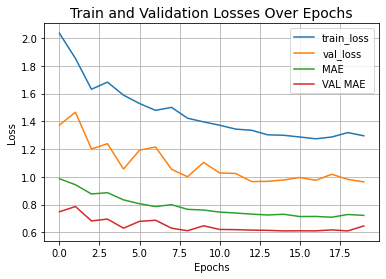

In [81]:
plt.plot(model_1_hist3.history["loss"], label="train_loss")
plt.plot(model_1_hist3.history["val_loss"], label="val_loss")
plt.plot(model_1_hist3.history["mean_absolute_error"], label="MAE")
plt.plot(model_1_hist3.history["val_mean_absolute_error"], label="VAL MAE")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

## Training Model - 1 with entire subset and batch - 30 and epoch = 20

### Callbacks

In [82]:
callbackHelper4 = CallbackHelper(workspace)
model_checkpoint4 = callbackHelper4.create_callback(callback_name="MC",experiment="/model-1_100P_30_20")
tensorboard_callback4 = callbackHelper4.create_callback(callback_name="TB",experiment="/model-1_40P_30_20")
early_stop_callback4 = callbackHelper4.create_callback(callback_name="ES",es_patience=0)
tqdm_callback4 = callbackHelper4.create_callback(callback_name="TQDM")
callback_list4 = [tqdm_callback4,model_checkpoint4,tensorboard_callback4]

Log file used =  /home/ubuntu/logs/model-1_100P_30_20/20221124-213246/MC
Log file used =  /home/ubuntu/logs/model-1_40P_30_20/20221124-213246/TB


In [83]:
callback_list4

### Train/Test Split

In [87]:
fractions = np.array([0.8, 0.1, 0.1])
# shuffle
df = dish_info
# split into 3 parts
train, val, test = np.array_split(
    df, (fractions[:-1].cumsum() * len(df)).astype(int))
print(train.shape)
print(val.shape)
print(test.shape)
sample_data = pd.concat([train,val])
sample_data.shape

(2608, 7)
(326, 7)
(327, 7)


(2934, 7)

### Normalize total_calories
* Divide it by total_mass of the dish 

In [88]:
sample_data["total_calories_norm"] = round(sample_data["total_calories"]/sample_data["total_mass"],2)

In [89]:
sample_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2934 entries, 0 to 2933
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dish_id              2934 non-null   object 
 1   total_calories       2934 non-null   float32
 2   total_mass           2934 non-null   float32
 3   total_fat            2934 non-null   float32
 4   total_carb           2934 non-null   float32
 5   total_protein        2934 non-null   float32
 6   image_path           2934 non-null   object 
 7   total_calories_norm  2934 non-null   float32
dtypes: float32(6), object(2)
memory usage: 137.5+ KB


### Data Generator

In [90]:
sample_train_gen  = generator.flow_from_dataframe(dataframe=sample_data,
                              target_size=(256,256),
                              x_col="image_path",
                              class_mode ="raw",
                              directory=None,
                              y_col = "total_calories_norm",
                              batch_size=1,
                              shuffle=True,
                              subset="training",
                              seed=123,
                              rescale=1.0/255)
sample_test_gen  = generator.flow_from_dataframe(dataframe=sample_data,
                              target_size=(256,256),
                              x_col="image_path",
                              class_mode ="raw",
                              directory=None,
                              batch_size=1,
                              seed=123,
                              y_col = "total_calories_norm",
                              subset="validation",
                              rescale=1.0/255)

Found 2348 validated image filenames.
Found 586 validated image filenames.


### Fit Model

In [91]:
batch4 = 30
num_epochs4 = 20

model_1_hist4 = vit_model_1.fit(
        sample_train_gen,
        validation_data = sample_test_gen,
        batch_size=batch4,
        epochs=num_epochs4,
        callbacks = callback_list4
    )

Training:   0%|           0/20 ETA: ?s,  ?epochs/s

Epoch 1/20


0/2348           ETA: ?s - 

Epoch 1/20
   5/2348 [..............................] - ETA: 39s - loss: 3.6400 - mean_absolute_error: 1.1117 WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0149s vs `on_train_batch_end` time: 0.0154s). Check your callbacks.


2345/2348 [============================>.] - ETA: 0s - loss: 1.2248 - mean_absolute_error: 0.7087

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_20/20221124-213246/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_20/20221124-213246/MC/assets


2348/2348 [==============================] - 63s 27ms/step - loss: 1.2244 - mean_absolute_error: 0.7090 - val_loss: 1.1255 - val_mean_absolute_error: 0.6650
Epoch 2/20


0/2348           ETA: ?s - 

Epoch 2/20
2346/2348 [============================>.] - ETA: 0s - loss: 1.2150 - mean_absolute_error: 0.7093

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_20/20221124-213246/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_20/20221124-213246/MC/assets


2348/2348 [==============================] - 62s 26ms/step - loss: 1.2145 - mean_absolute_error: 0.7093 - val_loss: 1.2083 - val_mean_absolute_error: 0.6530
Epoch 3/20


0/2348           ETA: ?s - 

Epoch 3/20
2346/2348 [============================>.] - ETA: 0s - loss: 1.2153 - mean_absolute_error: 0.7113

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_20/20221124-213246/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_20/20221124-213246/MC/assets


2348/2348 [==============================] - 62s 27ms/step - loss: 1.2148 - mean_absolute_error: 0.7112 - val_loss: 1.1635 - val_mean_absolute_error: 0.6471
Epoch 4/20


0/2348           ETA: ?s - 

Epoch 4/20
2347/2348 [============================>.] - ETA: 0s - loss: 1.1985 - mean_absolute_error: 0.7077

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_20/20221124-213246/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_20/20221124-213246/MC/assets


2348/2348 [==============================] - 62s 26ms/step - loss: 1.1980 - mean_absolute_error: 0.7075 - val_loss: 1.1392 - val_mean_absolute_error: 0.6515
Epoch 5/20


0/2348           ETA: ?s - 

Epoch 5/20
2347/2348 [============================>.] - ETA: 0s - loss: 1.2042 - mean_absolute_error: 0.7073

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_20/20221124-213246/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_20/20221124-213246/MC/assets


2348/2348 [==============================] - 62s 26ms/step - loss: 1.2038 - mean_absolute_error: 0.7072 - val_loss: 1.1411 - val_mean_absolute_error: 0.6504
Epoch 6/20


0/2348           ETA: ?s - 

Epoch 6/20
2347/2348 [============================>.] - ETA: 0s - loss: 1.1939 - mean_absolute_error: 0.7079

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_20/20221124-213246/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_20/20221124-213246/MC/assets


2348/2348 [==============================] - 62s 27ms/step - loss: 1.1935 - mean_absolute_error: 0.7077 - val_loss: 1.1982 - val_mean_absolute_error: 0.6515
Epoch 7/20


0/2348           ETA: ?s - 

Epoch 7/20
2346/2348 [============================>.] - ETA: 0s - loss: 1.1909 - mean_absolute_error: 0.7058

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_20/20221124-213246/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_20/20221124-213246/MC/assets


2348/2348 [==============================] - 62s 27ms/step - loss: 1.1901 - mean_absolute_error: 0.7056 - val_loss: 1.1496 - val_mean_absolute_error: 0.6478
Epoch 8/20


0/2348           ETA: ?s - 

Epoch 8/20
2348/2348 [==============================] - ETA: 0s - loss: 1.1838 - mean_absolute_error: 0.7026

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_20/20221124-213246/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_20/20221124-213246/MC/assets


2348/2348 [==============================] - 62s 26ms/step - loss: 1.1838 - mean_absolute_error: 0.7026 - val_loss: 1.1435 - val_mean_absolute_error: 0.6498
Epoch 9/20


0/2348           ETA: ?s - 

Epoch 9/20
2346/2348 [============================>.] - ETA: 0s - loss: 1.1807 - mean_absolute_error: 0.7015

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_20/20221124-213246/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_20/20221124-213246/MC/assets


2348/2348 [==============================] - 63s 27ms/step - loss: 1.1798 - mean_absolute_error: 0.7011 - val_loss: 1.1739 - val_mean_absolute_error: 0.6476
Epoch 10/20


0/2348           ETA: ?s - 

Epoch 10/20
2348/2348 [==============================] - ETA: 0s - loss: 1.1857 - mean_absolute_error: 0.7031

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_20/20221124-213246/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_20/20221124-213246/MC/assets


2348/2348 [==============================] - 62s 26ms/step - loss: 1.1857 - mean_absolute_error: 0.7031 - val_loss: 1.1410 - val_mean_absolute_error: 0.6501
Epoch 11/20


0/2348           ETA: ?s - 

Epoch 11/20
2348/2348 [==============================] - ETA: 0s - loss: 1.1865 - mean_absolute_error: 0.7024

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_20/20221124-213246/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_20/20221124-213246/MC/assets


2348/2348 [==============================] - 62s 27ms/step - loss: 1.1865 - mean_absolute_error: 0.7024 - val_loss: 1.1513 - val_mean_absolute_error: 0.6477
Epoch 12/20


0/2348           ETA: ?s - 

Epoch 12/20
2346/2348 [============================>.] - ETA: 0s - loss: 1.2007 - mean_absolute_error: 0.6996

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_20/20221124-213246/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_20/20221124-213246/MC/assets


2348/2348 [==============================] - 62s 27ms/step - loss: 1.2000 - mean_absolute_error: 0.6996 - val_loss: 1.1282 - val_mean_absolute_error: 0.6608
Epoch 13/20


0/2348           ETA: ?s - 

Epoch 13/20
2346/2348 [============================>.] - ETA: 0s - loss: 1.1692 - mean_absolute_error: 0.6962

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_20/20221124-213246/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_20/20221124-213246/MC/assets


2348/2348 [==============================] - 61s 26ms/step - loss: 1.1685 - mean_absolute_error: 0.6961 - val_loss: 1.1402 - val_mean_absolute_error: 0.6510
Epoch 14/20


0/2348           ETA: ?s - 

Epoch 14/20
2347/2348 [============================>.] - ETA: 0s - loss: 1.1708 - mean_absolute_error: 0.6952

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_20/20221124-213246/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_20/20221124-213246/MC/assets


2348/2348 [==============================] - 63s 27ms/step - loss: 1.1704 - mean_absolute_error: 0.6951 - val_loss: 1.1446 - val_mean_absolute_error: 0.6491
Epoch 15/20


0/2348           ETA: ?s - 

Epoch 15/20
2346/2348 [============================>.] - ETA: 0s - loss: 1.1851 - mean_absolute_error: 0.7001

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_20/20221124-213246/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_20/20221124-213246/MC/assets


2348/2348 [==============================] - 63s 27ms/step - loss: 1.1843 - mean_absolute_error: 0.6998 - val_loss: 1.1497 - val_mean_absolute_error: 0.6476
Epoch 16/20


0/2348           ETA: ?s - 

Epoch 16/20
2347/2348 [============================>.] - ETA: 0s - loss: 1.1801 - mean_absolute_error: 0.6920

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_20/20221124-213246/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_20/20221124-213246/MC/assets


2348/2348 [==============================] - 62s 26ms/step - loss: 1.1796 - mean_absolute_error: 0.6917 - val_loss: 1.1287 - val_mean_absolute_error: 0.6598
Epoch 17/20


0/2348           ETA: ?s - 

Epoch 17/20
2345/2348 [============================>.] - ETA: 0s - loss: 1.3390 - mean_absolute_error: 0.7108

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_20/20221124-213246/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_20/20221124-213246/MC/assets


2348/2348 [==============================] - 63s 27ms/step - loss: 1.3376 - mean_absolute_error: 0.7104 - val_loss: 1.1341 - val_mean_absolute_error: 0.6544
Epoch 18/20


0/2348           ETA: ?s - 

Epoch 18/20
2345/2348 [============================>.] - ETA: 0s - loss: 1.1849 - mean_absolute_error: 0.7001

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_20/20221124-213246/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_20/20221124-213246/MC/assets


2348/2348 [==============================] - 62s 27ms/step - loss: 1.1842 - mean_absolute_error: 0.7002 - val_loss: 1.1607 - val_mean_absolute_error: 0.6465
Epoch 19/20


0/2348           ETA: ?s - 

Epoch 19/20
2347/2348 [============================>.] - ETA: 0s - loss: 1.2363 - mean_absolute_error: 0.6992

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_20/20221124-213246/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_20/20221124-213246/MC/assets


2348/2348 [==============================] - 61s 26ms/step - loss: 1.2359 - mean_absolute_error: 0.6992 - val_loss: 1.1502 - val_mean_absolute_error: 0.6471
Epoch 20/20


0/2348           ETA: ?s - 

Epoch 20/20
2345/2348 [============================>.] - ETA: 0s - loss: 1.1793 - mean_absolute_error: 0.6933

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_20/20221124-213246/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_20/20221124-213246/MC/assets


2348/2348 [==============================] - 62s 27ms/step - loss: 1.1789 - mean_absolute_error: 0.6933 - val_loss: 1.1360 - val_mean_absolute_error: 0.6523


In [92]:
!nvidia-smi

Thu Nov 24 22:02:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   32C    P0    54W / 400W |  39241MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
### Plots

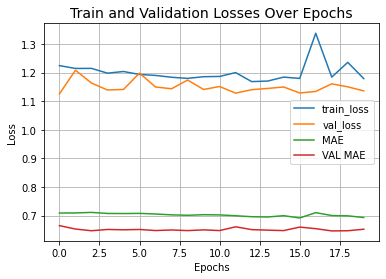

In [93]:
plt.plot(model_1_hist4.history["loss"], label="train_loss")
plt.plot(model_1_hist4.history["val_loss"], label="val_loss")
plt.plot(model_1_hist4.history["mean_absolute_error"], label="MAE")
plt.plot(model_1_hist4.history["val_mean_absolute_error"], label="VAL MAE")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

## Training Model - 1 with entire subset and batch - 30 and epoch = 30

### Callbacks

In [96]:
callbackHelper5 = CallbackHelper(workspace)
model_checkpoint5 = callbackHelper5.create_callback(callback_name="MC",experiment="/model-1_100P_30_30")
tensorboard_callback5 = callbackHelper5.create_callback(callback_name="TB",experiment="/model-1_40P_30_30")
early_stop_callback5 = callbackHelper5.create_callback(callback_name="ES",es_patience=0)
tqdm_callback5 = callbackHelper5.create_callback(callback_name="TQDM")
callback_list5 = [tqdm_callback5,model_checkpoint5,tensorboard_callback5]

Log file used =  /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC
Log file used =  /home/ubuntu/logs/model-1_40P_30_30/20221124-220423/TB


In [97]:
callback_list5

In [98]:
sample_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2934 entries, 0 to 2933
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dish_id              2934 non-null   object 
 1   total_calories       2934 non-null   float32
 2   total_mass           2934 non-null   float32
 3   total_fat            2934 non-null   float32
 4   total_carb           2934 non-null   float32
 5   total_protein        2934 non-null   float32
 6   image_path           2934 non-null   object 
 7   total_calories_norm  2934 non-null   float32
dtypes: float32(6), object(2)
memory usage: 137.5+ KB


### Fit Model

In [99]:
batch5 = 30
num_epochs5 = 30

model_1_hist5 = vit_model_1.fit(
        sample_train_gen,
        validation_data = sample_test_gen,
        batch_size=batch5,
        epochs=num_epochs5,
        callbacks = callback_list5
    )

Training:   0%|           0/30 ETA: ?s,  ?epochs/s

Epoch 1/30


0/2348           ETA: ?s - 

Epoch 1/30
   4/2348 [..............................] - ETA: 39s - loss: 0.3193 - mean_absolute_error: 0.4801 WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0152s vs `on_train_batch_end` time: 0.0170s). Check your callbacks.


2346/2348 [============================>.] - ETA: 0s - loss: 1.1769 - mean_absolute_error: 0.6995

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


2348/2348 [==============================] - 62s 26ms/step - loss: 1.1759 - mean_absolute_error: 0.6990 - val_loss: 1.1548 - val_mean_absolute_error: 0.6480
Epoch 2/30


0/2348           ETA: ?s - 

Epoch 2/30
2348/2348 [==============================] - ETA: 0s - loss: 1.2702 - mean_absolute_error: 0.7045

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


2348/2348 [==============================] - 63s 27ms/step - loss: 1.2702 - mean_absolute_error: 0.7045 - val_loss: 1.1488 - val_mean_absolute_error: 0.6465
Epoch 3/30


0/2348           ETA: ?s - 

Epoch 3/30
2347/2348 [============================>.] - ETA: 0s - loss: 2.1985 - mean_absolute_error: 0.7196

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


2348/2348 [==============================] - 62s 27ms/step - loss: 2.1976 - mean_absolute_error: 0.7195 - val_loss: 1.1264 - val_mean_absolute_error: 0.6631
Epoch 4/30


0/2348           ETA: ?s - 

Epoch 4/30
2348/2348 [==============================] - ETA: 0s - loss: 1.1988 - mean_absolute_error: 0.6997

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


2348/2348 [==============================] - 62s 26ms/step - loss: 1.1988 - mean_absolute_error: 0.6997 - val_loss: 1.1400 - val_mean_absolute_error: 0.6497
Epoch 5/30


0/2348           ETA: ?s - 

Epoch 5/30
2345/2348 [============================>.] - ETA: 0s - loss: 1.3488 - mean_absolute_error: 0.7046

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


2348/2348 [==============================] - 63s 27ms/step - loss: 1.3475 - mean_absolute_error: 0.7044 - val_loss: 1.1304 - val_mean_absolute_error: 0.6574
Epoch 6/30


0/2348           ETA: ?s - 

Epoch 6/30
2348/2348 [==============================] - ETA: 0s - loss: 3.8633 - mean_absolute_error: 0.7445

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


2348/2348 [==============================] - 62s 26ms/step - loss: 3.8633 - mean_absolute_error: 0.7445 - val_loss: 1.1268 - val_mean_absolute_error: 0.6625
Epoch 7/30


0/2348           ETA: ?s - 

Epoch 7/30
2348/2348 [==============================] - ETA: 0s - loss: 1.2591 - mean_absolute_error: 0.7019

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


2348/2348 [==============================] - 62s 27ms/step - loss: 1.2591 - mean_absolute_error: 0.7019 - val_loss: 1.1278 - val_mean_absolute_error: 0.6593
Epoch 8/30


0/2348           ETA: ?s - 

Epoch 8/30
2347/2348 [============================>.] - ETA: 0s - loss: 2.3006 - mean_absolute_error: 0.7332

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


2348/2348 [==============================] - 62s 27ms/step - loss: 2.2998 - mean_absolute_error: 0.7332 - val_loss: 1.3951 - val_mean_absolute_error: 0.7064
Epoch 9/30


0/2348           ETA: ?s - 

Epoch 9/30
2347/2348 [============================>.] - ETA: 0s - loss: 2.0622 - mean_absolute_error: 0.7361

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


2348/2348 [==============================] - 62s 27ms/step - loss: 2.0614 - mean_absolute_error: 0.7359 - val_loss: 1.1339 - val_mean_absolute_error: 0.6503
Epoch 10/30


0/2348           ETA: ?s - 

Epoch 10/30
2348/2348 [==============================] - ETA: 0s - loss: 1.7044 - mean_absolute_error: 0.7209

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


2348/2348 [==============================] - 62s 27ms/step - loss: 1.7044 - mean_absolute_error: 0.7209 - val_loss: 1.1292 - val_mean_absolute_error: 0.6596
Epoch 11/30


0/2348           ETA: ?s - 

Epoch 11/30
2346/2348 [============================>.] - ETA: 0s - loss: 1.5948 - mean_absolute_error: 0.7189

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


2348/2348 [==============================] - 62s 27ms/step - loss: 1.5946 - mean_absolute_error: 0.7191 - val_loss: 1.1433 - val_mean_absolute_error: 0.6454
Epoch 12/30


0/2348           ETA: ?s - 

Epoch 12/30
2347/2348 [============================>.] - ETA: 0s - loss: 1.2670 - mean_absolute_error: 0.6982

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


2348/2348 [==============================] - 62s 26ms/step - loss: 1.2675 - mean_absolute_error: 0.6986 - val_loss: 1.1344 - val_mean_absolute_error: 0.6521
Epoch 13/30


0/2348           ETA: ?s - 

Epoch 13/30
2347/2348 [============================>.] - ETA: 0s - loss: 1.4119 - mean_absolute_error: 0.7047

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


2348/2348 [==============================] - 63s 27ms/step - loss: 1.4113 - mean_absolute_error: 0.7045 - val_loss: 1.1248 - val_mean_absolute_error: 0.6644
Epoch 14/30


0/2348           ETA: ?s - 

Epoch 14/30
2347/2348 [============================>.] - ETA: 0s - loss: 1.9370 - mean_absolute_error: 0.7241

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


2348/2348 [==============================] - 62s 26ms/step - loss: 1.9361 - mean_absolute_error: 0.7238 - val_loss: 1.1308 - val_mean_absolute_error: 0.6531
Epoch 15/30


0/2348           ETA: ?s - 

Epoch 15/30
2347/2348 [============================>.] - ETA: 0s - loss: 2.3946 - mean_absolute_error: 0.7380

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


2348/2348 [==============================] - 63s 27ms/step - loss: 2.3936 - mean_absolute_error: 0.7378 - val_loss: 1.1284 - val_mean_absolute_error: 0.6588
Epoch 16/30


0/2348           ETA: ?s - 

Epoch 16/30
2345/2348 [============================>.] - ETA: 0s - loss: 1.3494 - mean_absolute_error: 0.7084

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


2348/2348 [==============================] - 62s 27ms/step - loss: 1.3484 - mean_absolute_error: 0.7084 - val_loss: 1.1302 - val_mean_absolute_error: 0.6583
Epoch 17/30


0/2348           ETA: ?s - 

Epoch 17/30
2348/2348 [==============================] - ETA: 0s - loss: 2.9681 - mean_absolute_error: 0.7459

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


2348/2348 [==============================] - 62s 26ms/step - loss: 2.9681 - mean_absolute_error: 0.7459 - val_loss: 1.1279 - val_mean_absolute_error: 0.6529
Epoch 18/30


0/2348           ETA: ?s - 

Epoch 18/30
2345/2348 [============================>.] - ETA: 0s - loss: 1.4220 - mean_absolute_error: 0.7196

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


2348/2348 [==============================] - 63s 27ms/step - loss: 1.4203 - mean_absolute_error: 0.7191 - val_loss: 1.1311 - val_mean_absolute_error: 0.6529
Epoch 19/30


0/2348           ETA: ?s - 

Epoch 19/30
2346/2348 [============================>.] - ETA: 0s - loss: 1.6669 - mean_absolute_error: 0.7098

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


2348/2348 [==============================] - 63s 27ms/step - loss: 1.6656 - mean_absolute_error: 0.7097 - val_loss: 1.1433 - val_mean_absolute_error: 0.6440
Epoch 20/30


0/2348           ETA: ?s - 

Epoch 20/30
2347/2348 [============================>.] - ETA: 0s - loss: 1.5902 - mean_absolute_error: 0.7134

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


2348/2348 [==============================] - 62s 26ms/step - loss: 1.5899 - mean_absolute_error: 0.7134 - val_loss: 1.1217 - val_mean_absolute_error: 0.6729
Epoch 21/30


0/2348           ETA: ?s - 

Epoch 21/30
2348/2348 [==============================] - ETA: 0s - loss: 1.2405 - mean_absolute_error: 0.6932

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


2348/2348 [==============================] - 62s 27ms/step - loss: 1.2405 - mean_absolute_error: 0.6932 - val_loss: 1.1207 - val_mean_absolute_error: 0.6722
Epoch 22/30


0/2348           ETA: ?s - 

Epoch 22/30
2347/2348 [============================>.] - ETA: 0s - loss: 1.6684 - mean_absolute_error: 0.7013

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


2348/2348 [==============================] - 62s 26ms/step - loss: 1.6679 - mean_absolute_error: 0.7013 - val_loss: 1.1255 - val_mean_absolute_error: 0.6520
Epoch 23/30


0/2348           ETA: ?s - 

Epoch 23/30
2348/2348 [==============================] - ETA: 0s - loss: 1.4259 - mean_absolute_error: 0.7143

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


2348/2348 [==============================] - 62s 27ms/step - loss: 1.4259 - mean_absolute_error: 0.7143 - val_loss: 1.1225 - val_mean_absolute_error: 0.6575
Epoch 24/30


0/2348           ETA: ?s - 

Epoch 24/30
2348/2348 [==============================] - ETA: 0s - loss: 1.2622 - mean_absolute_error: 0.6975

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


2348/2348 [==============================] - 63s 27ms/step - loss: 1.2622 - mean_absolute_error: 0.6975 - val_loss: 1.1227 - val_mean_absolute_error: 0.6697
Epoch 25/30


0/2348           ETA: ?s - 

Epoch 25/30
2348/2348 [==============================] - ETA: 0s - loss: 1.2044 - mean_absolute_error: 0.6865

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


2348/2348 [==============================] - 62s 26ms/step - loss: 1.2044 - mean_absolute_error: 0.6865 - val_loss: 2.2694 - val_mean_absolute_error: 0.7031
Epoch 26/30


0/2348           ETA: ?s - 

Epoch 26/30
2346/2348 [============================>.] - ETA: 0s - loss: 4.1426 - mean_absolute_error: 0.7308

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


2348/2348 [==============================] - 62s 27ms/step - loss: 4.1392 - mean_absolute_error: 0.7305 - val_loss: 1.1147 - val_mean_absolute_error: 0.6803
Epoch 27/30


0/2348           ETA: ?s - 

Epoch 27/30
2346/2348 [============================>.] - ETA: 0s - loss: 2.1706 - mean_absolute_error: 0.7224

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


2348/2348 [==============================] - 63s 27ms/step - loss: 2.1715 - mean_absolute_error: 0.7230 - val_loss: 1.6143 - val_mean_absolute_error: 0.6760
Epoch 28/30


0/2348           ETA: ?s - 

Epoch 28/30
2346/2348 [============================>.] - ETA: 0s - loss: 4.8222 - mean_absolute_error: 0.7705

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


2348/2348 [==============================] - 62s 26ms/step - loss: 4.8185 - mean_absolute_error: 0.7704 - val_loss: 1.2626 - val_mean_absolute_error: 0.6914
Epoch 29/30


0/2348           ETA: ?s - 

Epoch 29/30
2347/2348 [============================>.] - ETA: 0s - loss: 7.9012 - mean_absolute_error: 0.7554

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


2348/2348 [==============================] - 63s 27ms/step - loss: 7.8979 - mean_absolute_error: 0.7551 - val_loss: 1.5043 - val_mean_absolute_error: 0.6645
Epoch 30/30


0/2348           ETA: ?s - 

Epoch 30/30
2348/2348 [==============================] - ETA: 0s - loss: 20.2551 - mean_absolute_error: 0.8056

INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


INFO:tensorflow:Assets written to: /home/ubuntu/logs/model-1_100P_30_30/20221124-220423/MC/assets


2348/2348 [==============================] - 62s 26ms/step - loss: 20.2551 - mean_absolute_error: 0.8056 - val_loss: 1.3577 - val_mean_absolute_error: 0.6782


In [100]:
!nvidia-smi

Thu Nov 24 22:39:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   32C    P0    58W / 400W |  39241MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
### Plots

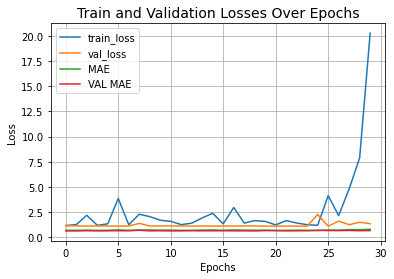

In [101]:
plt.plot(model_1_hist5.history["loss"], label="train_loss")
plt.plot(model_1_hist5.history["val_loss"], label="val_loss")
plt.plot(model_1_hist5.history["mean_absolute_error"], label="MAE")
plt.plot(model_1_hist5.history["val_mean_absolute_error"], label="VAL MAE")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()